## Libraries Import

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
from tqdm import tqdm

import tensorflow.keras.backend as K
import gc


# For preprocessing and modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
# Compute class weights to address imbalance
from sklearn.utils.class_weight import compute_class_weight

# For Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

from lime import lime_tabular

# import my custom function from utils notebook
import import_ipynb
import my_utils

import importlib
importlib.reload(my_utils)

from my_utils import *

pd.set_option('display.max_columns', None)

### Data and Global Variables Setup

In [3]:
#### GLOBAL VARIABLES:


# csv path for collecting test data across all Deep-Learning approaches
csv_path = "experiment_log_light_dataset_historical_features.csv"

In [ ]:
# import my custom function from utils notebook
import import_ipynb
import my_utils
import importlib
importlib.reload(my_utils)
from my_utils import *

train_data, test_data = get_original_training_data()

complete_df = pd.concat([train_data, test_data])

proc_train_data, proc_val_data, proc_test_data = data_processing_updated(complete_df, historical=True)

#print(proc_train_data.isnull().sum())
#print(proc_val_data.isnull().sum())
#print(proc_test_data.isnull().sum())

In [38]:
## Saving processed data to avoid expensive computations

proc_train_data.to_csv("proc_train_data.csv", index=False)
proc_val_data.to_csv("proc_val_data.csv", index=False)
proc_test_data.to_csv("proc_test_data.csv", index=False)




### Time Saver: Load processed Data

In [4]:
#Load the datasets from CSV files
proc_train_data = pd.read_csv("proc_train_data.csv")
proc_val_data = pd.read_csv("proc_val_data.csv")
proc_test_data = pd.read_csv("proc_test_data.csv")

## Encoding and Scale

In [5]:
# import my custom function from utils notebook
import import_ipynb
import my_utils
import importlib
importlib.reload(my_utils)
from my_utils import *

final_train_data, final_validation_data, final_test_data = encode_and_scale(proc_train_data, proc_val_data, proc_test_data) 

removing jobs missing in train dataset but existing in test dataset
Encode gender
Label Encoding
merchant
Fit on training data and get classes
Transform train_data
Transform validation_data
Transform test_data
category
Fit on training data and get classes
Transform train_data
Transform validation_data
Transform test_data
Scale continuous variables
fit_transform train_data
transform validation_data
transform test_data


In [24]:
final_test_data.columns

Index(['merchant', 'category', 'amt', 'gender', 'zip', 'city_pop', 'is_fraud',
       'hour', 'day', 'month', 'year', 'day_of_week', 'age', 'distance',
       'category_fraud_probability', 'merchant_fraud_probability',
       'fraud_prob_by_amt', 'hourly_fraud_probability'],
      dtype='object')

### Label Creation

In [6]:
# Split features and target
X_train = final_train_data.drop(['is_fraud', 'zip'], axis=1)
y_train = final_train_data['is_fraud']

X_val = final_validation_data.drop(['is_fraud', 'zip'], axis=1)
y_val = final_validation_data['is_fraud']

X_test = final_test_data.drop(['is_fraud', 'zip'], axis=1)
y_test = final_test_data['is_fraud']

## Address class imbalance with SMOTE
#smote = SMOTE(random_state=42)
#X_resampled, y_resampled = smote.fit_resample(X, y)

# Creating validation dataset with stratify strategy in order to keep the original labels proportion
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42, stratify=y_train)


X_test = X_test[X_train.columns]
X_val = X_val[X_train.columns]

print("X_train shape: ", X_train.shape)
print("X_val shape: ", X_val.shape)
print("X_test shape: ", X_test.shape)

X_train shape:  (280000, 16)
X_val shape:  (60000, 16)
X_test shape:  (60000, 16)


In [44]:
print(y_train.sum() / y_train.shape*100)
print(y_val.sum() / y_val.shape*100)
print(y_test.sum() / y_test.shape*100)

[0.46964286]
[0.4]
[0.47166667]


### Class Weights Definition

In [7]:


class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: weight for i, weight in enumerate(class_weights)}

print(class_weights)

{0: 0.5023592945440193, 1: 106.4638783269962}


## Creating Baseline Models

### Naive Random Classifier

using a fraud rate of:  0.004696428571428571
Accuracy: 0.9904
Precision-Recall AUC Score: 0.0047

Confusion Matrix:
[[59425   292]
 [  283     0]]


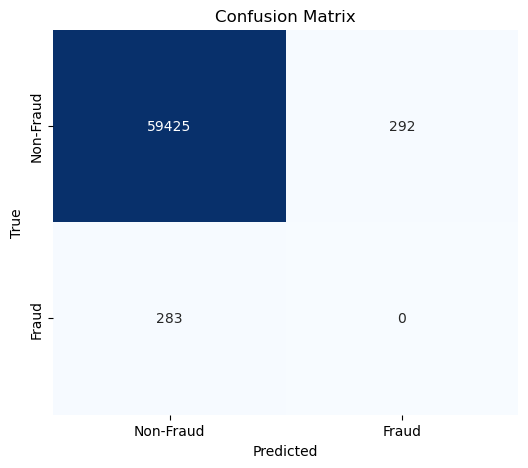


Classification Report:
              precision    recall  f1-score   support

           0     0.9953    0.9951    0.9952     59717
           1     0.0000    0.0000    0.0000       283

    accuracy                         0.9904     60000
   macro avg     0.4976    0.4976    0.4976     60000
weighted avg     0.9906    0.9904    0.9905     60000

Experiment data saved to experiment_log_light_dataset_historical_features.csv


In [151]:
def random_classifier_baseline(y_train, X_test):
    """
    Generates random predictions, assigning the fraud class with a given probability.
    :param X_test: Features of the test set (used to determine the number of instances).
    :param fraud_rate: Proportion of fraud cases 
    :return: Random predictions for the test set.
    """
    
    fraud_rate = y_train.values.sum() / y_train.shape[0]
    print("using a fraud rate of: ", fraud_rate)
    
    num_samples = X_test.shape[0]
    random_predictions = np.random.choice(
        [0, 1], size=num_samples, p=[1 - fraud_rate, fraud_rate]
    )
    return random_predictions, fraud_rate

# Example usage:
# y_random_baseline = random_classifier_baseline(X_test)

random_predictions, fraud_rate = random_classifier_baseline(y_train, X_test)


test_accuracy, test_auc, test_recall, test_f1, test_precision = compute_main_scores(y_test, random_predictions, random_predictions)


experiment_data = {
    "model_type": f"Random Classifier Baseline",
    "note": "Random Classifier light dataset with historical features",
    "dataset_size": "400K",
    "hyperparameters": {"fraud_rate": fraud_rate},
    "excluded_features": [],
    "best_threshold": None,
    "test_precision": test_precision,
    "test_recall": test_recall,
    "test_f1": test_f1,
    "test_accuracy": test_accuracy,
    "test_auc": test_auc,
    "test_aic": None,
    "test_smd": None
}

save_experiment_data(experiment_data, csv_path)

compare_test_performance(csv_path)

In [53]:
test_recall

0.0021321961620469083

### Decision Tree Classifier

Accuracy: 0.9977
Precision-Recall AUC Score: 0.5954

Confusion Matrix:
[[59636    81]
 [   55   228]]



Classification Report:
              precision    recall  f1-score   support

           0     0.9991    0.9986    0.9989     59717
           1     0.7379    0.8057    0.7703       283

    accuracy                         0.9977     60000
   macro avg     0.8685    0.9021    0.8846     60000
weighted avg     0.9978    0.9977    0.9978     60000

Feature Importance:
                       Feature  Importance
1                     category    0.266948
14           fraud_prob_by_amt    0.202280
15    hourly_fraud_probability    0.127556
2                          amt    0.091048
10                         age    0.086854
12  category_fraud_probability    0.063261
4                     city_pop    0.032521
5                         hour    0.030625
11                    distance    0.023026
3                       gender    0.021052
6                          day    0.016796
0                     merchant    0.010858
9                  day_of_week    0.010805
13  merchant_fraud_probabil

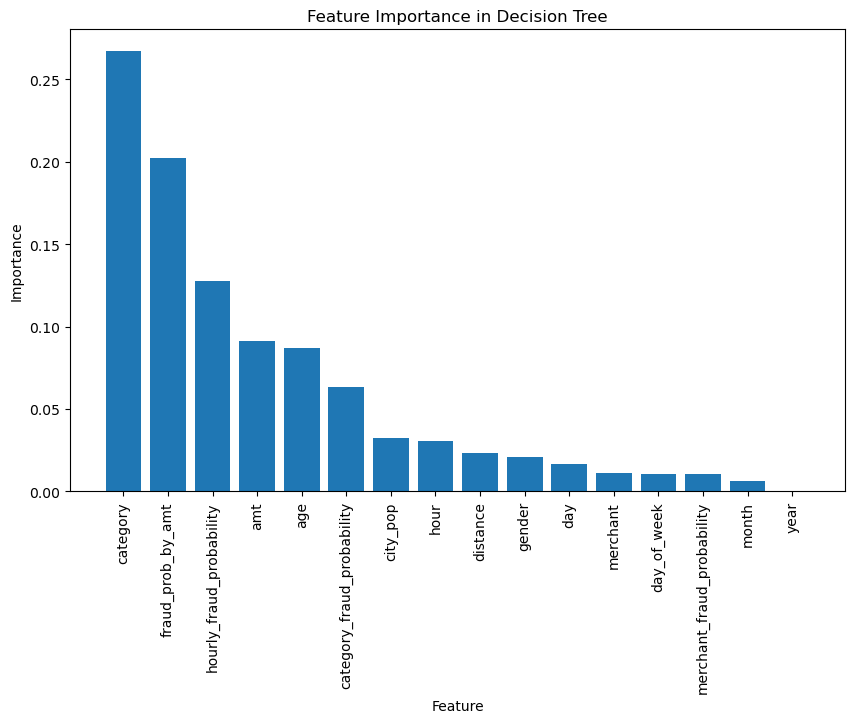

Experiment data saved to experiment_log_light_dataset_historical_features.csv


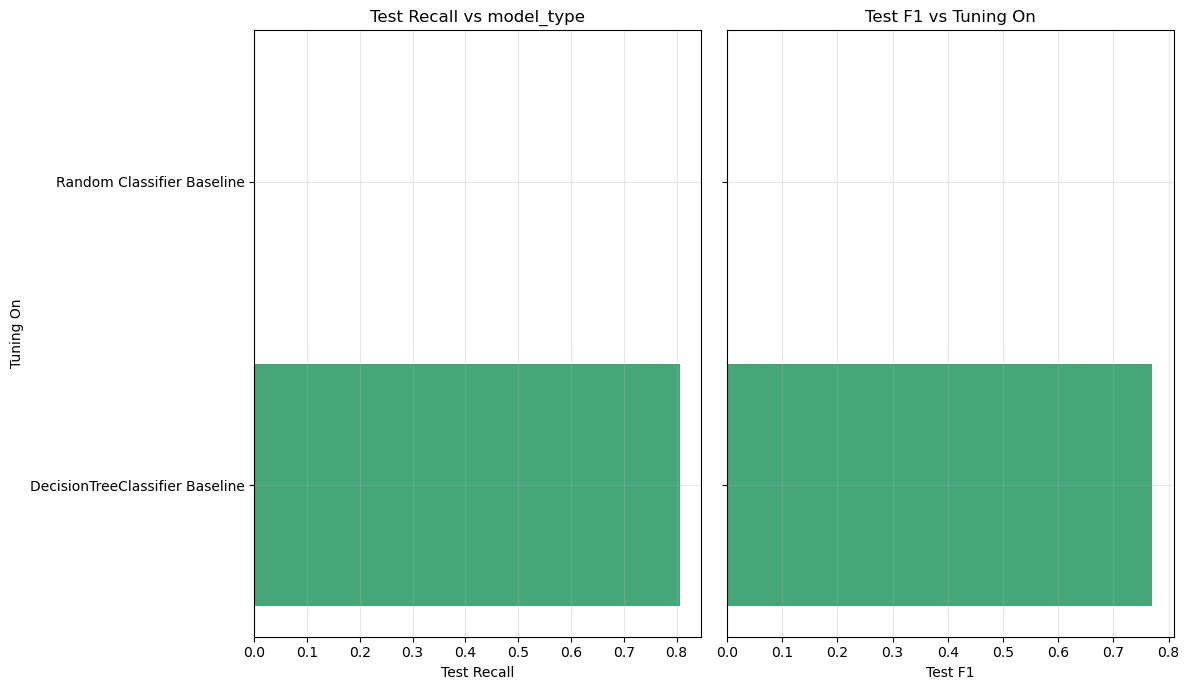

In [152]:
# Train a Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42, criterion='gini')
dt_classifier.fit(X_train, y_train)

# Make predictions on the test set
tree_predictions = dt_classifier.predict(X_test)

# Extract probabilities for class 1
tree_probabilities = dt_classifier.predict_proba(X_test)[:, 1]  

test_accuracy, test_auc, test_recall, test_f1, test_precision = compute_main_scores(y_test, tree_predictions, tree_probabilities)

# Get feature importances
feature_importances = dt_classifier.feature_importances_

# Create a DataFrame to store feature importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the sorted feature importances
print("Feature Importance:")
print(feature_importance_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance in Decision Tree')
plt.show()


experiment_data = {
    "model_type": f"DecisionTreeClassifier Baseline",
    "note": "DecisionTreeClassifier light dataset with historical features",
    "dataset_size": "400K",
    "hyperparameters": {"criterion": 'gini'},
    "excluded_features": [],
    "best_threshold": None,
    "test_precision": test_precision,
    "test_recall": test_recall,
    "test_f1": test_f1,
    "test_accuracy": test_accuracy,
    "test_auc": test_auc,
    "test_aic": None,
    "test_smd": None,
}

save_experiment_data(experiment_data, csv_path)

compare_test_performance(csv_path)

# 1 Feed-Forward Neural Network

In [160]:
val_performance = {}
val_performance['hyperparams'] = []
val_performance['val_AUC'] = []


validation_performance = {
    "model_type": "",
    "excluded_features": [],
    'num_blocks_list': "",
    'units': "",
    'reduction_rate': "",
    'l1_reg': "",
    'l2_reg': "",
    'dropout': "",
    'learning_rate': "",
    'batch_size': "",
    'class_weights': "",
    "val_precision": "",
    "val_recall": "",
    "val_f1": "",
    "val_accuracy": "",
    "val_auc": "",
    "val_aic": "",
    "val_smd": "",
}



# Initialize variables to track the best model and parameters
best_model = None
best_params = None
best_val_auc = -np.inf
best_threshold = None

Hyperparameter Tuning:   0%|                                                                     | 0/6 [00:00<?, ?it/s]

Training with parameters: {'batch_size': 128, 'class_weights': {0: 0.5023592945440193, 1: 106.4638783269962}, 'dropout': 0.0, 'l1_reg': 0.0005, 'l2_reg': 0.0, 'learning_rate': 5e-05, 'num_blocks_list': 9, 'reduction_rate': 0.75, 'units': 512}
Model building...
Model: "sequential_170"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1599 (Dense)          (None, 512)               8704      
                                                                 
 batch_normalization_1174 (  (None, 512)               2048      
 BatchNormalization)                                             
                                                                 
 dropout_988 (Dropout)       (None, 512)               0         
                                                                 
 dense_1600 (Dense)          (None, 384)               196992    
                                                       

Epoch 20/50
2188/2188 [==============================] - 63s 29ms/step - loss: 2.6433 - accuracy: 0.9271 - pr_auc: 0.3384 - val_loss: 2.5628 - val_accuracy: 0.8982 - val_pr_auc: 0.3990
Epoch 21/50
2188/2188 [==============================] - 64s 29ms/step - loss: 2.4370 - accuracy: 0.9345 - pr_auc: 0.3454 - val_loss: 2.2936 - val_accuracy: 0.9544 - val_pr_auc: 0.3807
Epoch 22/50
2188/2188 [==============================] - 63s 29ms/step - loss: 2.2433 - accuracy: 0.9361 - pr_auc: 0.3484 - val_loss: 2.1140 - val_accuracy: 0.9624 - val_pr_auc: 0.2508
Epoch 23/50
2188/2188 [==============================] - 62s 28ms/step - loss: 2.0759 - accuracy: 0.9353 - pr_auc: 0.3614 - val_loss: 2.0730 - val_accuracy: 0.9344 - val_pr_auc: 0.1400
Epoch 24/50
2188/2188 [==============================] - 65s 30ms/step - loss: 1.9356 - accuracy: 0.9344 - pr_auc: 0.3414 - val_loss: 1.8552 - val_accuracy: 0.9498 - val_pr_auc: 0.1697
Epoch 25/50
2188/2188 [==============================] - 62s 29ms/step - lo

1875/1875 [==============================] - 7s 3ms/step
Accuracy: 0.9370
Precision-Recall AUC Score: 0.2112

Confusion Matrix:
[[56031  3729]
 [   53   187]]


<string>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
Hyperparameter Tuning:  17%|█████████▌                                               | 1/6 [53:23<4:26:59, 3203.92s/it]


Classification Report:
              precision    recall  f1-score   support

           0     0.9991    0.9376    0.9674     59760
           1     0.0478    0.7792    0.0900       240

    accuracy                         0.9370     60000
   macro avg     0.5234    0.8584    0.5287     60000
weighted avg     0.9952    0.9370    0.9638     60000

(60000,)
(60000,)
(60000, 16)
Standardized mean difference of non-fraud gender:  0.11531017160521206
Adverse Impact Ratio of non-fraud for gender:  0.9703658352799337
Adverse Impact Ratio of accuracy for gender:  0.9681131214997518
BEST PARAMS SINCE NOW:
BEST VAL AUC:  0.529148967139251
{'batch_size': 128, 'class_weights': {0: 0.5023592945440193, 1: 106.4638783269962}, 'dropout': 0.0, 'l1_reg': 0.0001, 'l2_reg': 0.0, 'learning_rate': 5e-05, 'num_blocks_list': 9, 'reduction_rate': 0.75, 'units': 512}
Training with parameters: {'batch_size': 128, 'class_weights': {0: 0.5023592945440193, 1: 106.4638783269962}, 'dropout': 0.0, 'l1_reg': 0.0005, 

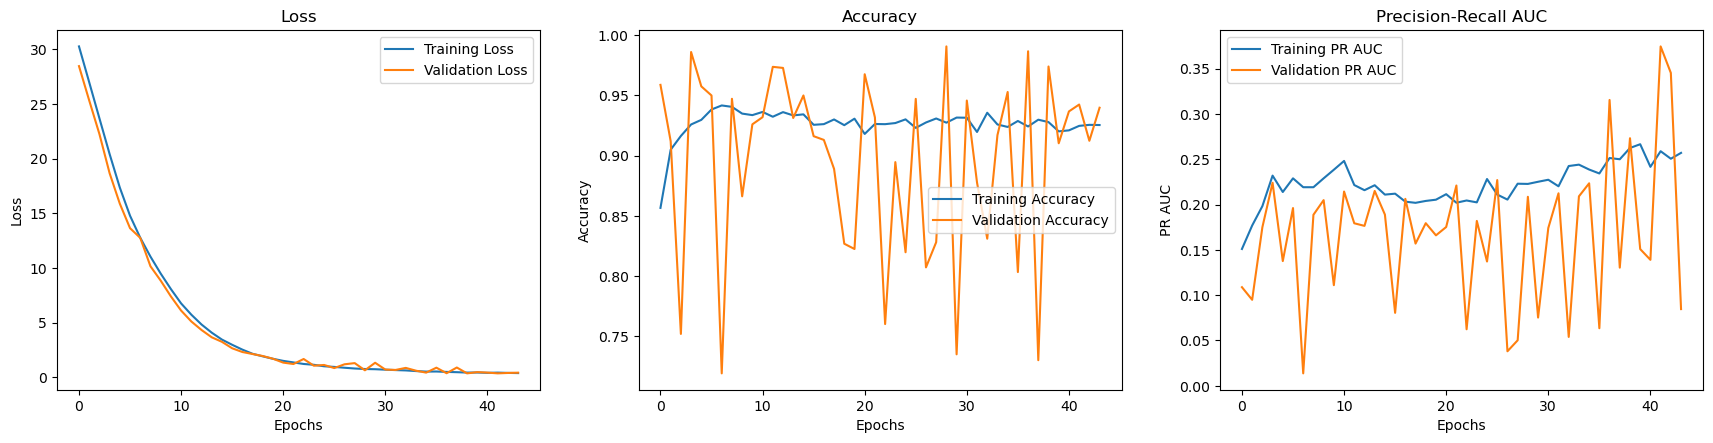

1875/1875 [==============================] - 9s 5ms/step
Accuracy: 0.9739
Precision-Recall AUC Score: 0.2855

Confusion Matrix:
[[58246  1514]
 [   51   189]]


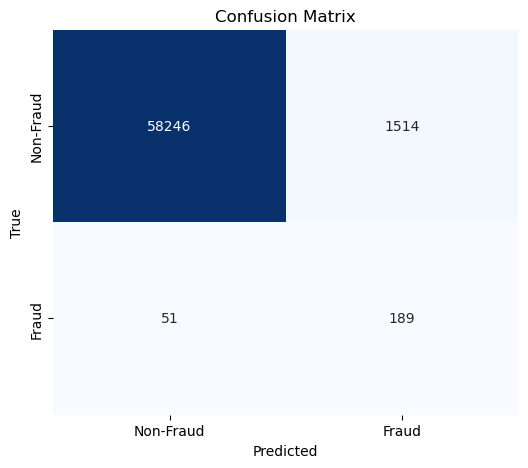


Classification Report:
              precision    recall  f1-score   support

           0     0.9991    0.9747    0.9867     59760
           1     0.1110    0.7875    0.1945       240

    accuracy                         0.9739     60000
   macro avg     0.5551    0.8811    0.5906     60000
weighted avg     0.9956    0.9739    0.9836     60000

(60000,)
(60000,)
(60000, 16)


<string>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
Hyperparameter Tuning:  33%|█████████████████▎                                  | 2/6 [12:03:25<27:44:28, 24967.20s/it]

Standardized mean difference of non-fraud gender:  0.018484551841111953
Adverse Impact Ratio of non-fraud for gender:  0.9968542282296411
Adverse Impact Ratio of accuracy for gender:  0.9938614238270612
BEST PARAMS SINCE NOW:
BEST VAL AUC:  0.529148967139251
{'batch_size': 128, 'class_weights': {0: 0.5023592945440193, 1: 106.4638783269962}, 'dropout': 0.0, 'l1_reg': 0.0001, 'l2_reg': 0.0, 'learning_rate': 5e-05, 'num_blocks_list': 9, 'reduction_rate': 0.75, 'units': 512}
Training with parameters: {'batch_size': 128, 'class_weights': {0: 0.5023592945440193, 1: 106.4638783269962}, 'dropout': 0.0, 'l1_reg': 0.0005, 'l2_reg': 0.0, 'learning_rate': 5e-05, 'num_blocks_list': 10, 'reduction_rate': 0.75, 'units': 512}
Model building...
Model: "sequential_172"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1619 (Dense)          (None, 512)               8704      
                                        

Epoch 15/50
2188/2188 [==============================] - 46s 21ms/step - loss: 4.9269 - accuracy: 0.9376 - pr_auc: 0.2798 - val_loss: 4.7660 - val_accuracy: 0.9714 - val_pr_auc: 0.1286
Epoch 16/50
2188/2188 [==============================] - 46s 21ms/step - loss: 4.6028 - accuracy: 0.9326 - pr_auc: 0.3210 - val_loss: 4.4601 - val_accuracy: 0.9159 - val_pr_auc: 0.1567
Epoch 17/50
2188/2188 [==============================] - 45s 21ms/step - loss: 4.3114 - accuracy: 0.9389 - pr_auc: 0.3436 - val_loss: 4.0936 - val_accuracy: 0.9556 - val_pr_auc: 0.3456
Epoch 18/50
2188/2188 [==============================] - 45s 21ms/step - loss: 4.0173 - accuracy: 0.9344 - pr_auc: 0.3224 - val_loss: 3.8589 - val_accuracy: 0.9409 - val_pr_auc: 0.1818
Epoch 19/50
2188/2188 [==============================] - 45s 21ms/step - loss: 3.7711 - accuracy: 0.9257 - pr_auc: 0.3209 - val_loss: 3.5622 - val_accuracy: 0.9381 - val_pr_auc: 0.3047
Epoch 20/50
2188/2188 [==============================] - 45s 21ms/step - lo

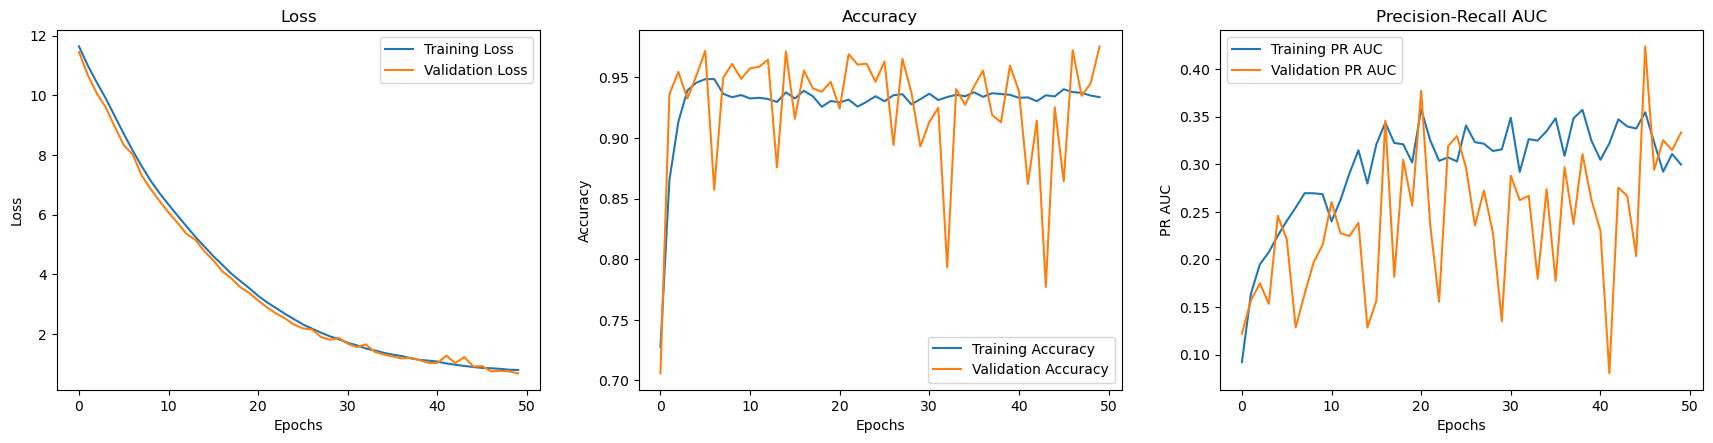

1875/1875 [==============================] - 5s 2ms/step
Accuracy: 0.9755
Precision-Recall AUC Score: 0.3021

Confusion Matrix:
[[58331  1429]
 [   42   198]]


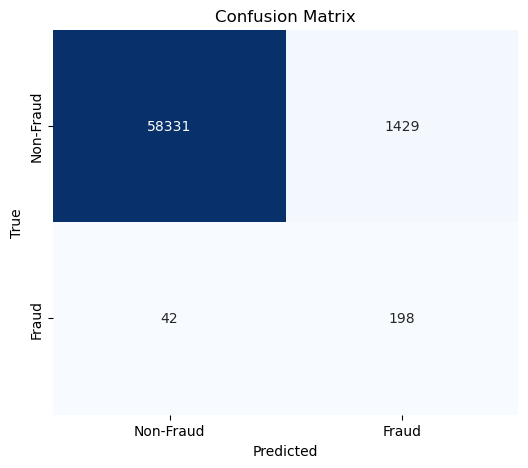


Classification Report:
              precision    recall  f1-score   support

           0     0.9993    0.9761    0.9875     59760
           1     0.1217    0.8250    0.2121       240

    accuracy                         0.9755     60000
   macro avg     0.5605    0.9005    0.5998     60000
weighted avg     0.9958    0.9755    0.9844     60000

(60000,)
(60000,)
(60000, 16)


<string>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
Hyperparameter Tuning:  50%|██████████████████████████                          | 3/6 [12:41:49<12:10:55, 14618.59s/it]

Standardized mean difference of non-fraud gender:  0.0325333796197379
Adverse Impact Ratio of non-fraud for gender:  0.9946099411712906
Adverse Impact Ratio of accuracy for gender:  0.9915086228900571
BEST PARAMS SINCE NOW:
BEST VAL AUC:  0.529148967139251
{'batch_size': 128, 'class_weights': {0: 0.5023592945440193, 1: 106.4638783269962}, 'dropout': 0.0, 'l1_reg': 0.0001, 'l2_reg': 0.0, 'learning_rate': 5e-05, 'num_blocks_list': 9, 'reduction_rate': 0.75, 'units': 512}
Training with parameters: {'batch_size': 128, 'class_weights': {0: 0.5023592945440193, 1: 106.4638783269962}, 'dropout': 0.0, 'l1_reg': 0.0005, 'l2_reg': 0.0, 'learning_rate': 5e-05, 'num_blocks_list': 10, 'reduction_rate': 0.75, 'units': 1024}
Model building...
Model: "sequential_173"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1630 (Dense)          (None, 1024)              17408     
                                         

Epoch 15/50
2188/2188 [==============================] - 92s 42ms/step - loss: 4.2187 - accuracy: 0.9423 - pr_auc: 0.2094 - val_loss: 4.0369 - val_accuracy: 0.8486 - val_pr_auc: 0.1470
Epoch 16/50
2188/2188 [==============================] - 96s 44ms/step - loss: 3.6548 - accuracy: 0.9328 - pr_auc: 0.1983 - val_loss: 3.3893 - val_accuracy: 0.9294 - val_pr_auc: 0.1655
Epoch 17/50
2188/2188 [==============================] - 98s 45ms/step - loss: 3.1794 - accuracy: 0.9362 - pr_auc: 0.2135 - val_loss: 3.5061 - val_accuracy: 0.7534 - val_pr_auc: 0.0292
Epoch 18/50
2188/2188 [==============================] - 96s 44ms/step - loss: 2.8624 - accuracy: 0.9380 - pr_auc: 0.2129 - val_loss: 2.7150 - val_accuracy: 0.8885 - val_pr_auc: 0.1960
Epoch 19/50
2188/2188 [==============================] - 98s 45ms/step - loss: 2.4853 - accuracy: 0.9317 - pr_auc: 0.2067 - val_loss: 2.3243 - val_accuracy: 0.9520 - val_pr_auc: 0.1356
Epoch 20/50
2188/2188 [==============================] - 100s 46ms/step - l

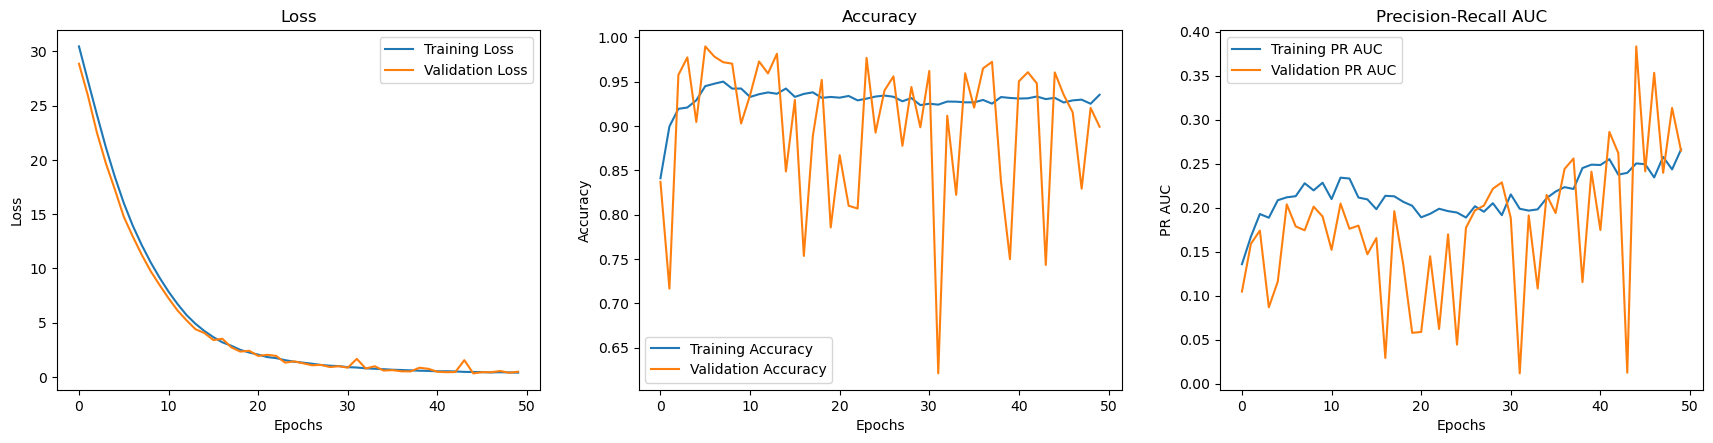

1875/1875 [==============================] - 12s 6ms/step
Accuracy: 0.9605
Precision-Recall AUC Score: 0.3872

Confusion Matrix:
[[57445  2315]
 [   58   182]]


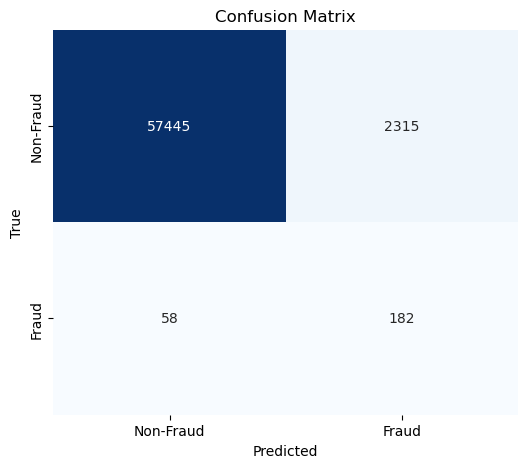

<string>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
Hyperparameter Tuning:  67%|███████████████████████████████████▎                 | 4/6 [13:59:32<5:56:16, 10688.43s/it]


Classification Report:
              precision    recall  f1-score   support

           0     0.9990    0.9613    0.9798     59760
           1     0.0729    0.7583    0.1330       240

    accuracy                         0.9605     60000
   macro avg     0.5359    0.8598    0.5564     60000
weighted avg     0.9953    0.9605    0.9764     60000

(60000,)
(60000,)
(60000, 16)
Standardized mean difference of non-fraud gender:  0.16642278084403683
Adverse Impact Ratio of non-fraud for gender:  0.9666879303886622
Adverse Impact Ratio of accuracy for gender:  0.9644671480322073
BEST PARAMS SINCE NOW:
BEST VAL AUC:  0.529148967139251
{'batch_size': 128, 'class_weights': {0: 0.5023592945440193, 1: 106.4638783269962}, 'dropout': 0.0, 'l1_reg': 0.0001, 'l2_reg': 0.0, 'learning_rate': 5e-05, 'num_blocks_list': 9, 'reduction_rate': 0.75, 'units': 512}
Training with parameters: {'batch_size': 128, 'class_weights': {0: 0.5023592945440193, 1: 106.4638783269962}, 'dropout': 0.0, 'l1_reg': 0.0005, 

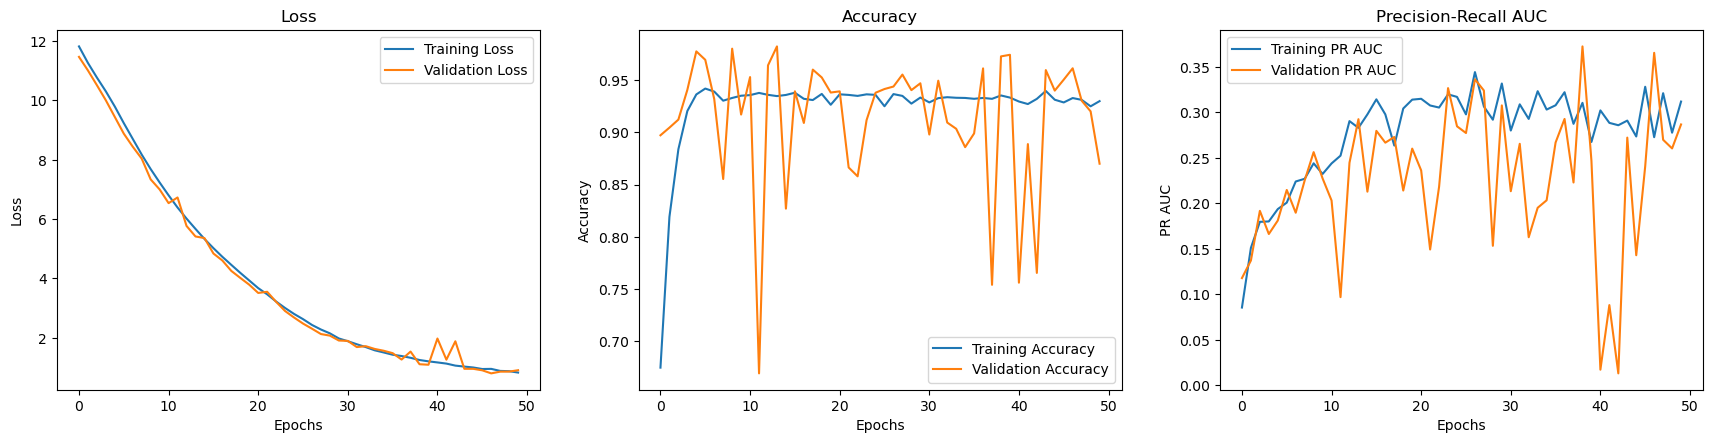

1875/1875 [==============================] - 4s 2ms/step
Accuracy: 0.8700
Precision-Recall AUC Score: 0.2951

Confusion Matrix:
[[52008  7752]
 [   49   191]]


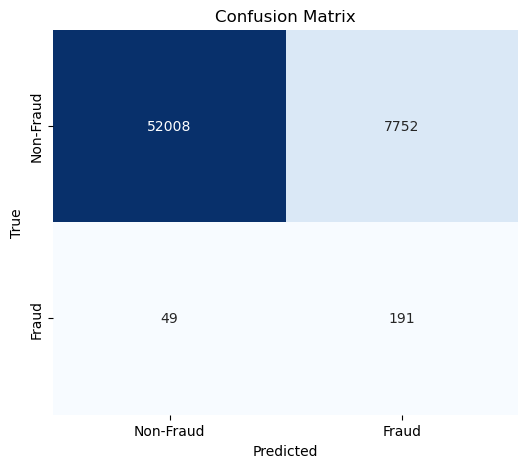

<string>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
Hyperparameter Tuning:  83%|█████████████████████████████████████████████         | 5/6 [14:38:43<2:08:01, 7681.98s/it]


Classification Report:
              precision    recall  f1-score   support

           0     0.9991    0.8703    0.9302     59760
           1     0.0240    0.7958    0.0467       240

    accuracy                         0.8700     60000
   macro avg     0.5116    0.8331    0.4885     60000
weighted avg     0.9952    0.8700    0.9267     60000

(60000,)
(60000,)
(60000, 16)
Standardized mean difference of non-fraud gender:  0.10113792437159683
Adverse Impact Ratio of non-fraud for gender:  0.961578730527541
Adverse Impact Ratio of accuracy for gender:  0.9591761475670891
BEST PARAMS SINCE NOW:
BEST VAL AUC:  0.529148967139251
{'batch_size': 128, 'class_weights': {0: 0.5023592945440193, 1: 106.4638783269962}, 'dropout': 0.0, 'l1_reg': 0.0001, 'l2_reg': 0.0, 'learning_rate': 5e-05, 'num_blocks_list': 9, 'reduction_rate': 0.75, 'units': 512}
Training with parameters: {'batch_size': 128, 'class_weights': {0: 0.5023592945440193, 1: 106.4638783269962}, 'dropout': 0.0, 'l1_reg': 0.0005, '

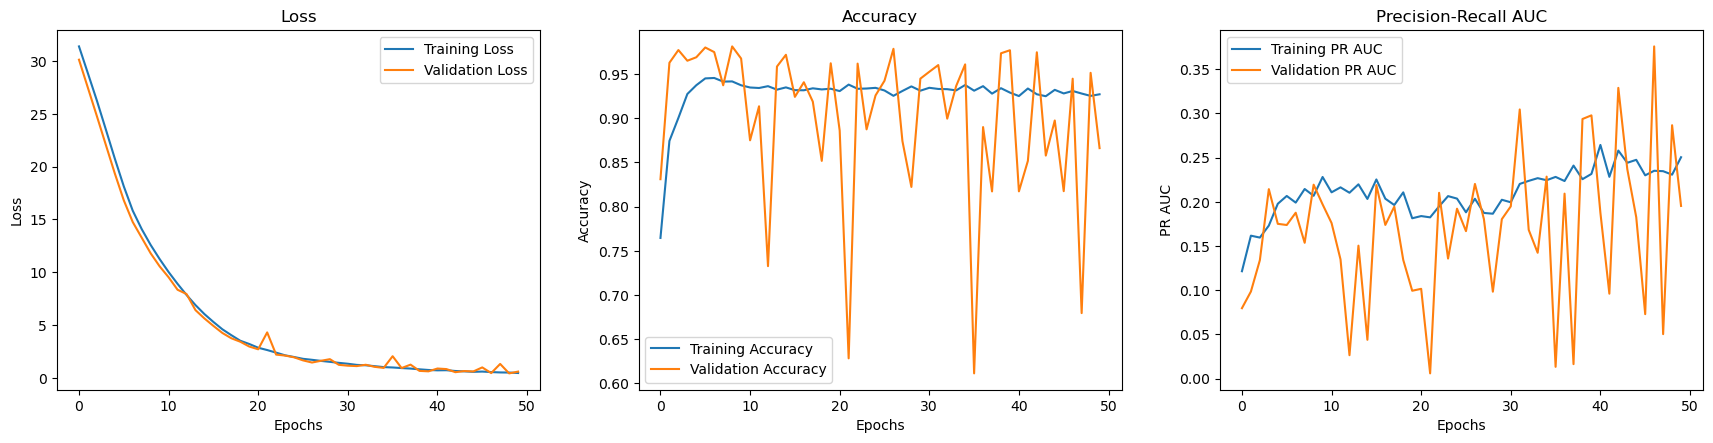

1875/1875 [==============================] - 10s 5ms/step
Accuracy: 0.8662
Precision-Recall AUC Score: 0.2909

Confusion Matrix:
[[51770  7990]
 [   37   203]]


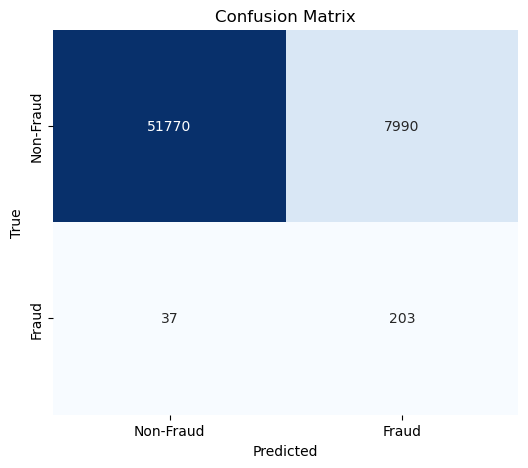


Classification Report:


<string>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
Hyperparameter Tuning: 100%|████████████████████████████████████████████████████████| 6/6 [15:53:02<00:00, 9530.38s/it]

              precision    recall  f1-score   support

           0     0.9993    0.8663    0.9281     59760
           1     0.0248    0.8458    0.0481       240

    accuracy                         0.8662     60000
   macro avg     0.5120    0.8561    0.4881     60000
weighted avg     0.9954    0.8662    0.9245     60000

(60000,)
(60000,)
(60000, 16)
Standardized mean difference of non-fraud gender:  0.07975636189646927
Adverse Impact Ratio of non-fraud for gender:  0.9689736408548169
Adverse Impact Ratio of accuracy for gender:  0.9661485635110811
BEST PARAMS SINCE NOW:
BEST VAL AUC:  0.529148967139251
{'batch_size': 128, 'class_weights': {0: 0.5023592945440193, 1: 106.4638783269962}, 'dropout': 0.0, 'l1_reg': 0.0001, 'l2_reg': 0.0, 'learning_rate': 5e-05, 'num_blocks_list': 9, 'reduction_rate': 0.75, 'units': 512}
Best Hyperparameters: {'batch_size': 128, 'class_weights': {0: 0.5023592945440193, 1: 106.4638783269962}, 'dropout': 0.0, 'l1_reg': 0.0001, 'l2_reg': 0.0, 'learning_rat

In [179]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import roc_auc_score
import numpy as np
import tensorflow as tf
# Best Hyperparameters: {'batch_size': 128, 'class_weights': {0: 0.5015224789539674, 1: 164.7058823529412}, 'dropout': 0.0, 'l1_reg': 0.0, 'l2_reg': 0.0, 'learning_rate': 5e-05, 'num_blocks_list': 5, 'units': 128}
# Define hyperparameters to tune
param_grid = {
    'num_blocks_list': [9, 10, 11],
    'units': [512, 1024],
    'reduction_rate': [0.75],
    'l1_reg': [0.0005],#, 0.0001], 
    'l2_reg': [0.0], #0.0001], 
    'dropout': [0.0], #, 0.1],
    'learning_rate': [0.00005], #[0.00005],
    'batch_size': [128],
    'class_weights': [
        class_weights,
        #{0: 1.0, 1: 0.5},  # Example custom weighting
    ]
}

# Create combinations of hyperparameters
param_combinations = list(ParameterGrid(param_grid))



with tqdm(total=len(param_combinations), desc="Hyperparameter Tuning") as pbar:
    # Iterate through all parameter combinations
    for params in param_combinations:
        print(f"Training with parameters: {params}")

        # Create the model with the current hyperparameters
        model, hyperparams = create_FFN(
            input_dim=X_train.shape[1],
            num_blocks=params['num_blocks_list'],
            initial_units=params['units'],
            dropout_rate=params['dropout'],
            activation='relu',
            learning_rate=params['learning_rate'],
            l1_reg=params['l1_reg'], 
            l2_reg=params['l2_reg'],
            reduction_rate = params['reduction_rate']
        )

        # Early stopping to prevent overfitting
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=5, restore_best_weights=True
        )

        # Train the model
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=50,
            batch_size=params['batch_size'],
            class_weight=params['class_weights'],
            callbacks=[early_stopping]
        )
        
        print("Plotting training and validation metrics across epochs")
        plot_performance(history)
        
        # Evaluate AUC on the validation set
        y_val_pred = model.predict(X_val)
        y_val_pred_classes = (y_val_pred > 0.5).astype(int)
        
        # Compute main scores
        val_accuracy, val_auc, val_recall, val_f1, val_precision = compute_main_scores(
            y_val, y_val_pred_classes, y_val_pred
        )
        
        # Fairness evaluation
        integrated_df_test, smd_test, air_outcome_test, air_out_accuracy_test = fairness_evaluation(
                        model, X_val, y_val, y_val_pred_classes, "gender", 0, 1, 0
        )
        
        # populating validation_performance dict
        validation_performance["model_type"] = "FFN"
        validation_performance["excluded_features"] = []
        validation_performance["num_blocks_list"] = params['num_blocks_list']
        validation_performance["units"] = params['units']
        validation_performance["reduction_rate"] = params['reduction_rate']
        validation_performance["l1_reg"] = params['l1_reg']
        validation_performance["l2_reg"] = params['l2_reg']
        validation_performance["dropout"] = params['dropout']
        validation_performance["learning_rate"] = params['learning_rate']
        validation_performance["batch_size"] = params['batch_size']
        validation_performance["class_weights"] = params['class_weights']
        validation_performance["val_precision"] = val_precision
        validation_performance["val_recall"] = val_recall
        validation_performance["val_f1"] = val_f1
        validation_performance["val_accuracy"] = val_accuracy
        validation_performance["val_auc"] = val_auc
        validation_performance["val_aic"] = air_outcome_test
        validation_performance["val_smd"] = smd_test


        # Update the best model if the current one is better
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            best_model = model
            best_params = params
        
        print("BEST PARAMS SINCE NOW:")
        print("BEST VAL AUC: ", best_val_auc)
        print(best_params)
        
        # Save the information to the CSV file
        save_validation_info(validation_performance, "FFN_validation_data.csv")
        
        pbar.update(1)
        
# Output the best hyperparameters and validation AUC
print(f"Best Hyperparameters: {best_params}")
print(f"Best Validation AUC: {best_val_auc:.4f}")


In [ ]:
# Extract records with the best validation metrics
best_auc_record = perf_df.loc[perf_df['val_auc'].idxmax(), hyperparam_columns]
best_f1_record = perf_df.loc[perf_df['val_f1'].idxmax(), hyperparam_columns]
best_recall_record = perf_df.loc[perf_df['val_recall'].idxmax(), hyperparam_columns]

# Convert extracted hyperparameters to dictionary
best_auc_hyperparams = best_auc_record.to_dict()
best_f1_hyperparams = best_f1_record.to_dict()
best_recall_hyperparams = best_recall_record.to_dict()

# Function to create and train FFN model
def train_ffn_model(params, X_train):
    model, hyperparams = create_FFN(
        input_dim=X_train.shape[1],
        num_blocks=params['num_blocks_list'],
        initial_units=params['units'],
        dropout_rate=params['dropout'],
        activation='relu',
        learning_rate=params['learning_rate'],
        l1_reg=params['l1_reg'], 
        l2_reg=params['l2_reg'],
        reduction_rate=params['reduction_rate']
    )
    return model, hyperparams

# Train models
model_auc, hyperparams_auc = train_ffn_model(best_auc_hyperparams, X_train)
model_f1, hyperparams_f1 = train_ffn_model(best_f1_hyperparams, X_train)
model_recall, hyperparams_recall = train_ffn_model(best_recall_hyperparams, X_train)

1875/1875 [==============================] - 4s 2ms/step
Best Threshold (Recall >= 0.8 & Max F1-Score): 0.97
Precision: 0.45, Recall: 0.71, F1-Score: 0.55


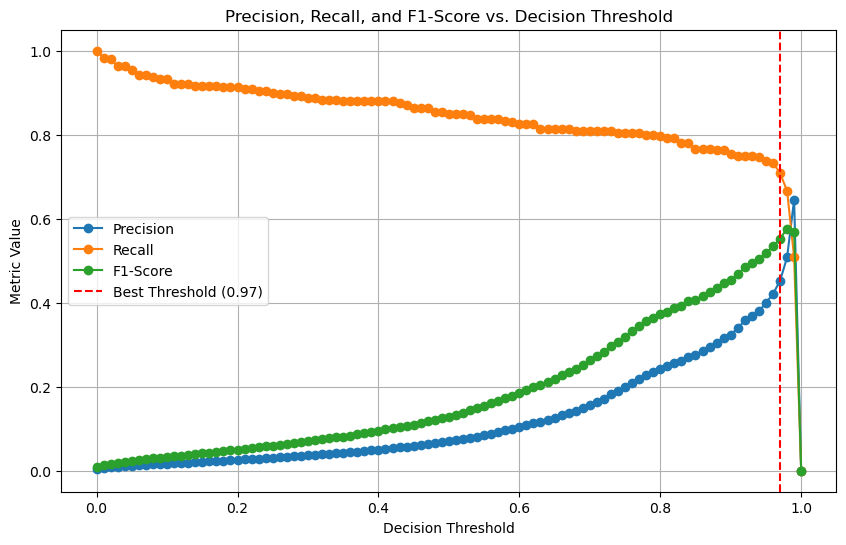

Best Threshold: 0.97
1875/1875 [==============================] - 4s 2ms/step
Accuracy: 0.9955
Precision-Recall AUC Score: 0.6192

Confusion Matrix:
[[59512   205]
 [   64   219]]


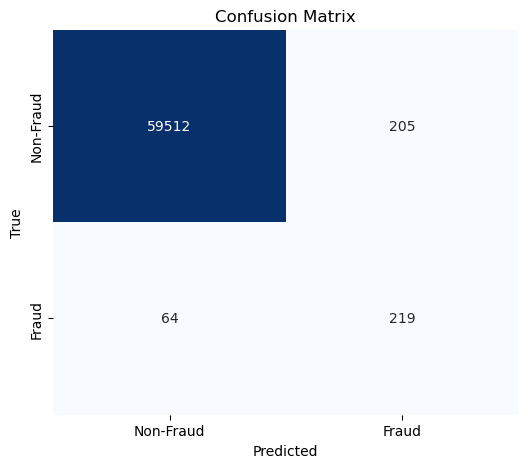


Classification Report:
              precision    recall  f1-score   support

           0     0.9989    0.9966    0.9977     59717
           1     0.5165    0.7739    0.6195       283

    accuracy                         0.9955     60000
   macro avg     0.7577    0.8852    0.8086     60000
weighted avg     0.9967    0.9955    0.9960     60000

Test Metrics:
Accuracy: 0.9955
AUC: 0.6192
Recall: 0.7739
F1 Score: 0.6195
Precision: 0.5165
(60000,)
(60000,)
(60000, 16)
Standardized mean difference of non-fraud gender:  -0.027680007943705696
Adverse Impact Ratio of non-fraud for gender:  1.0023557161815415
Adverse Impact Ratio of accuracy for gender:  0.9983142269197337
Experiment data saved to experiment_log_light_dataset_historical_features.csv


<string>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


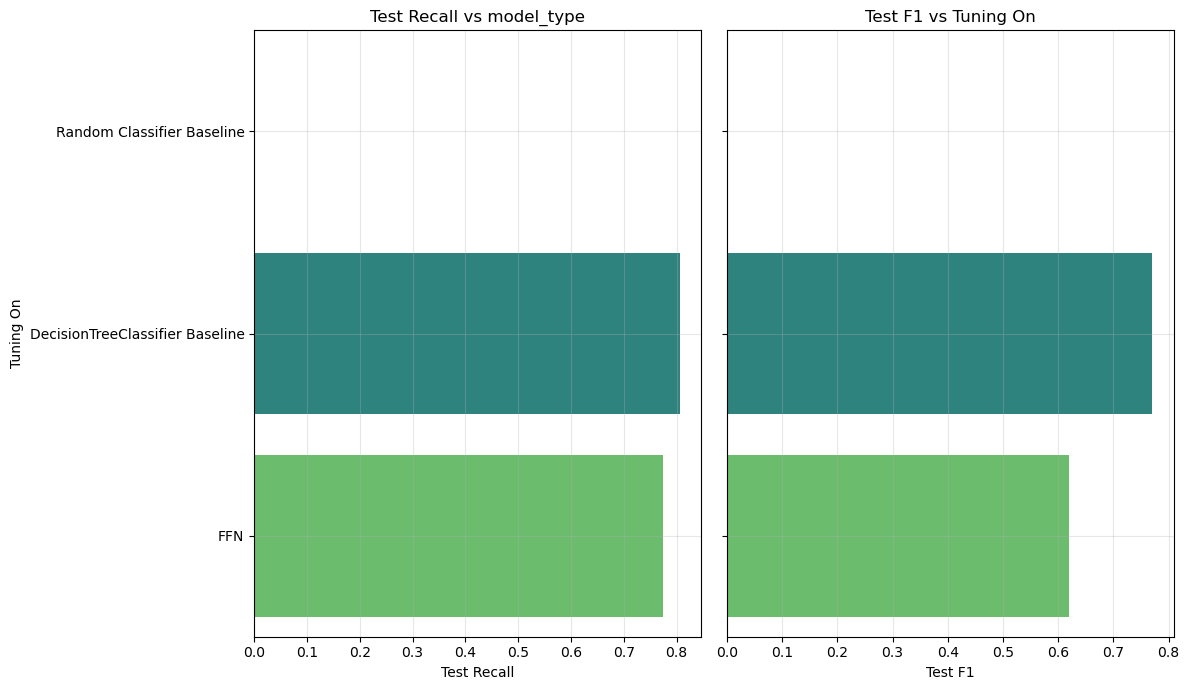

In [189]:
# Evaluate the best model's threshold on the validation set
best_threshold = threshold_metric_evaluation(best_model, X_val, y_val)
print(f"Best Threshold: {best_threshold}")

# Test the best model on the test set
y_test_pred = best_model.predict(X_test)
y_test_pred_classes = (y_test_pred >= best_threshold).astype(int)

# Compute main scores
test_accuracy, test_auc, test_recall, test_f1, test_precision = compute_main_scores(
    y_test, y_test_pred_classes, y_test_pred
)

# Print test evaluation metrics
print("Test Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"AUC: {test_auc:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print(f"Precision: {test_precision:.4f}")

# Fairness evaluation
integrated_df_test, smd_test, air_outcome_test, air_out_accuracy_test = fairness_evaluation(
    best_model, X_test, y_test, y_test_pred_classes, "gender", 0, 1, 0
)


experiment_data = {
    "model_type": f"FFN",
    "note": "FFN light dataset with historical features",
    "dataset": "400K",
    "hyperparameters": best_params,
    "excluded_features": [],
    "best_threshold": best_threshold,
    "test_precision": test_precision,
    "test_recall": test_recall,
    "test_f1": test_f1,
    "test_accuracy": test_accuracy,
    "test_auc": test_auc,
    "test_aic": air_outcome_test,
    "test_smd": smd_test,
}

save_experiment_data(experiment_data, csv_path)

compare_test_performance(csv_path)

# 2 FFN with Custom Focal Function

In [9]:
def compute_alpha(y_train):
    """
    Compute alpha values for focal loss based on class distribution.

    Parameters:
    - y_train: numpy array or list of binary labels (0 or 1) representing the dataset.

    Returns:
    - alpha_0: Weight for class 0 (majority class).
    - alpha_1: Weight for class 1 (minority class).
    """

    # Count the number of occurrences of each class
    num_class_1 = sum(y_train)  # Number of positive samples (y=1)
    num_class_0 = len(y_train) - num_class_1  # Number of negative samples (y=0)
    
    # Compute class fractions
    f1 = num_class_1 / len(y_train)  # Fraction of class 1 samples
    f0 = num_class_0 / len(y_train)  # Fraction of class 0 samples

    # Compute alpha values using inverse frequency
    alpha_1 = (1 - f1) / (1 - f0)  # Give more weight to minority class
    alpha_0 = f1 / f0  # Give less weight to majority class

    return alpha_0, alpha_1


alpha_0, alpha_1 = compute_alpha(y_train)

print(f"Computed alpha_0 (for class 0): {alpha_0:.4f}")
print(f"Computed alpha_1 (for class 1): {alpha_1:.4f}")


Computed alpha_0 (for class 0): 0.0047
Computed alpha_1 (for class 1): 211.9278


In [25]:
val_performance = {}
val_performance['hyperparams'] = []
val_performance['val_AUC'] = []


validation_performance = {
    "model_type": "",
    "excluded_features": [],
    "alpha": [],
    "gamma": "",
    'num_blocks_list': "",
    'units': "",
    'reduction_rate': "",
    'l1_reg': "",
    'l2_reg': "",
    'dropout': "",
    'learning_rate': "",
    'batch_size': "",
    'class_weights': "",
    "val_precision": "",
    "val_recall": "",
    "val_f1": "",
    "val_accuracy": "",
    "val_auc": "",
    "val_aic": "",
    "val_smd": "",
}



# Initialize variables to track the best model and parameters
best_model = None
best_params = None
best_val_auc = -np.inf
best_threshold = None


# Clear Keras/TensorFlow Session
K.clear_session()
# Force Garbage Collection
gc.collect()

13675

Hyperparameter Tuning:   0%|                                                                    | 0/16 [00:00<?, ?it/s]

Training with parameters: {'alpha': [1, 2], 'batch_size': 128, 'class_weights': {0: 0.5023592945440193, 1: 106.4638783269962}, 'dropout': 0.0, 'gamma': 0, 'l1_reg': 0.001, 'l2_reg': 0.0, 'learning_rate': 5e-05, 'num_blocks_list': 7, 'reduction_rate': 0.75, 'units': 256}
Model building...
Custom Focal Loss Params
alpha:  [1, 2]
gamma:  0
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               4352      
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 192)       

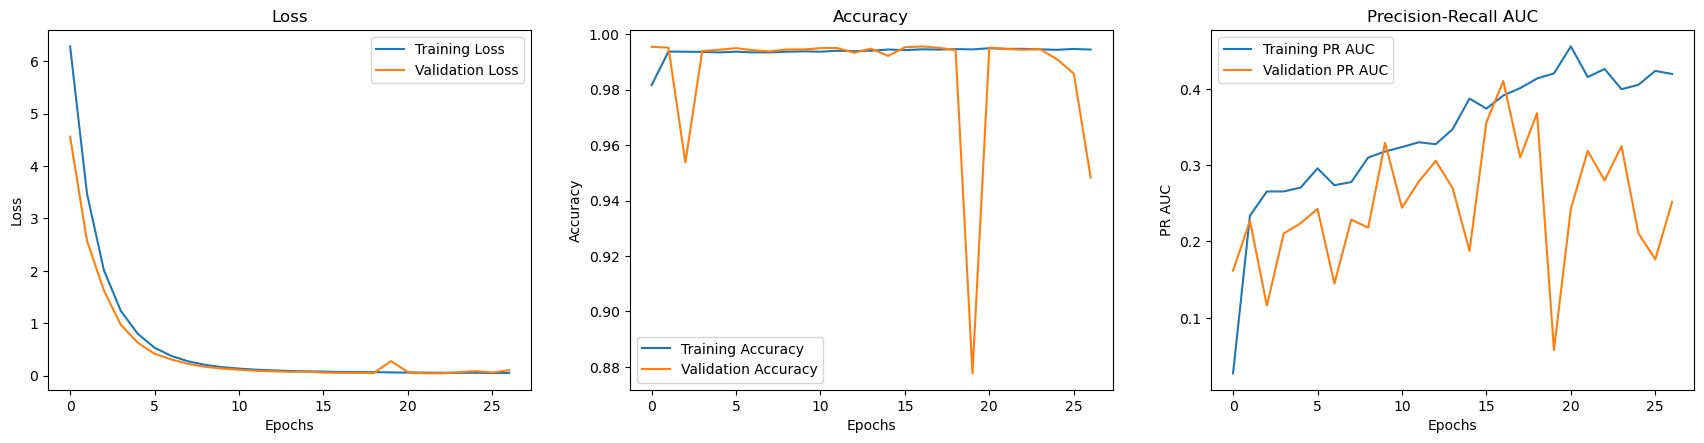

1875/1875 [==============================] - 3s 1ms/step
Accuracy: 0.9947
Precision-Recall AUC Score: 0.3227

Confusion Matrix:
[[59549   211]
 [  109   131]]


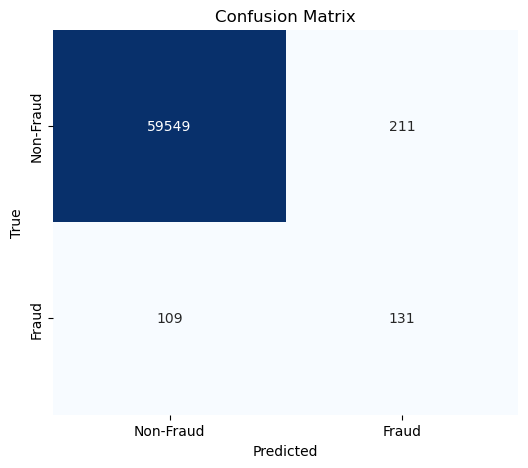


Classification Report:
              precision    recall  f1-score   support

           0     0.9982    0.9965    0.9973     59760
           1     0.3830    0.5458    0.4502       240

    accuracy                         0.9947     60000
   macro avg     0.6906    0.7712    0.7237     60000
weighted avg     0.9957    0.9947    0.9951     60000

(60000,)
(60000,)
(60000, 16)
Standardized mean difference of non-fraud gender:  -0.029638674481783263
Adverse Impact Ratio of non-fraud for gender:  1.0022677637407629
Adverse Impact Ratio of accuracy for gender:  1.0011784381813131
BEST PARAMS SINCE NOW:
BEST VAL AUC:  0.6567275493469814
{'alpha': [1, 2], 'batch_size': 128, 'class_weights': {0: 0.5023592945440193, 1: 106.4638783269962}, 'dropout': 0.0, 'gamma': 0, 'l1_reg': 0.0001, 'l2_reg': 0.0, 'learning_rate': 5e-05, 'num_blocks_list': 7, 'reduction_rate': 0.75, 'units': 256}


<string>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
Hyperparameter Tuning:   6%|███▌                                                     | 1/16 [07:33<1:53:19, 453.31s/it]

Training with parameters: {'alpha': [1, 2], 'batch_size': 128, 'class_weights': {0: 0.5023592945440193, 1: 106.4638783269962}, 'dropout': 0.0, 'gamma': 0, 'l1_reg': 0.001, 'l2_reg': 0.001, 'learning_rate': 5e-05, 'num_blocks_list': 7, 'reduction_rate': 0.75, 'units': 256}
Model building...
Custom Focal Loss Params
alpha:  [1, 2]
gamma:  0
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               4352      
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 192)     

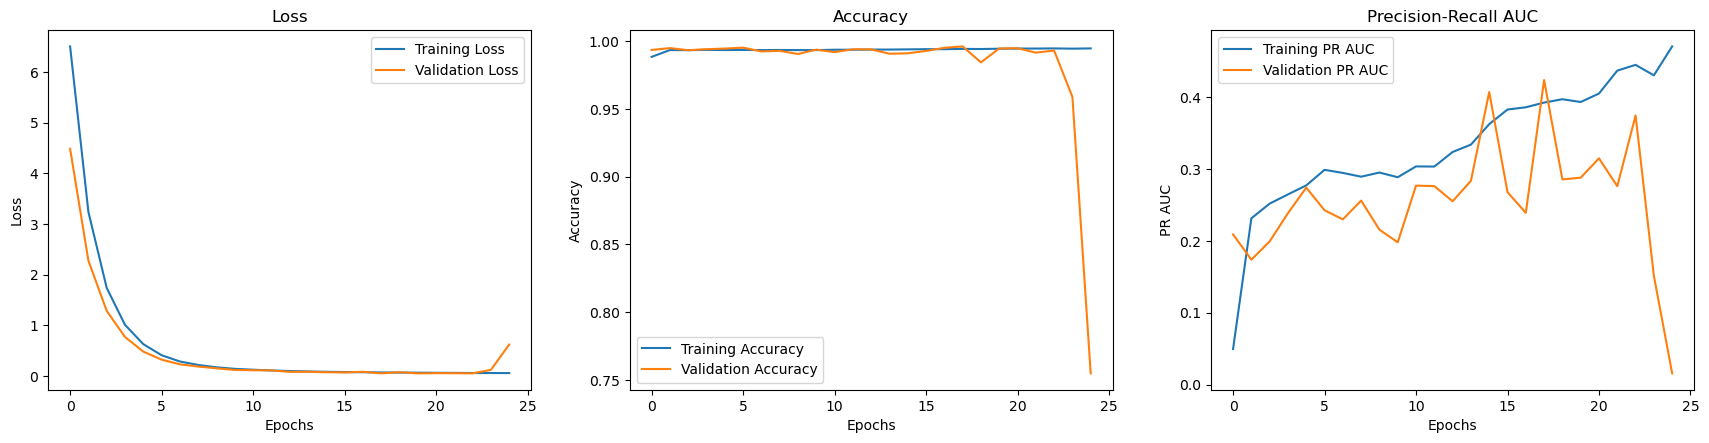

1875/1875 [==============================] - 3s 2ms/step
Accuracy: 0.9945
Precision-Recall AUC Score: 0.2910

Confusion Matrix:
[[59528   232]
 [   99   141]]


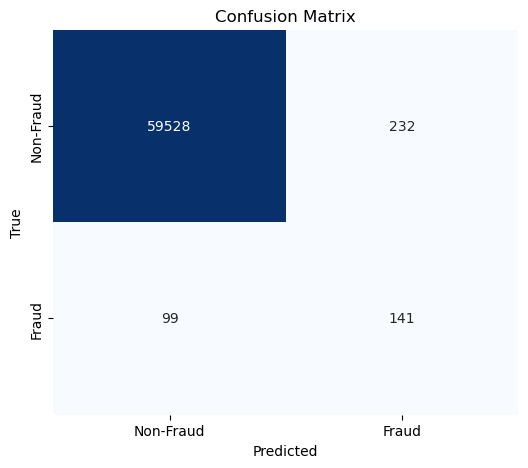


Classification Report:
              precision    recall  f1-score   support

           0     0.9983    0.9961    0.9972     59760
           1     0.3780    0.5875    0.4600       240

    accuracy                         0.9945     60000
   macro avg     0.6882    0.7918    0.7286     60000
weighted avg     0.9959    0.9945    0.9951     60000

(60000,)
(60000,)
(60000, 16)
Standardized mean difference of non-fraud gender:  -0.019118235152228238
Adverse Impact Ratio of non-fraud for gender:  1.0015220688960667
Adverse Impact Ratio of accuracy for gender:  1.0000972823072807
BEST PARAMS SINCE NOW:
BEST VAL AUC:  0.6567275493469814
{'alpha': [1, 2], 'batch_size': 128, 'class_weights': {0: 0.5023592945440193, 1: 106.4638783269962}, 'dropout': 0.0, 'gamma': 0, 'l1_reg': 0.0001, 'l2_reg': 0.0, 'learning_rate': 5e-05, 'num_blocks_list': 7, 'reduction_rate': 0.75, 'units': 256}


<string>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
Hyperparameter Tuning:  12%|███████▏                                                 | 2/16 [15:00<1:44:55, 449.70s/it]

Training with parameters: {'alpha': [1, 2], 'batch_size': 128, 'class_weights': {0: 0.5023592945440193, 1: 106.4638783269962}, 'dropout': 0.0, 'gamma': 0, 'l1_reg': 0.0, 'l2_reg': 0.0, 'learning_rate': 5e-05, 'num_blocks_list': 7, 'reduction_rate': 0.75, 'units': 256}
Model building...
Custom Focal Loss Params
alpha:  [1, 2]
gamma:  0
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               4352      
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 192)         

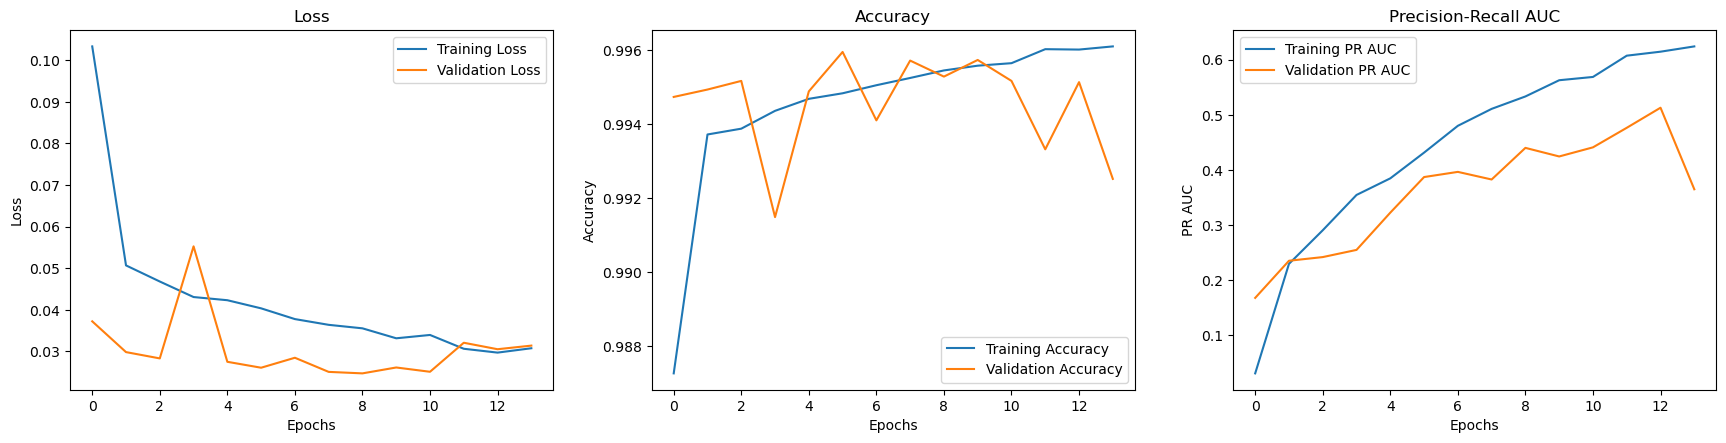

1875/1875 [==============================] - 3s 2ms/step
Accuracy: 0.9953
Precision-Recall AUC Score: 0.4429

Confusion Matrix:
[[59581   179]
 [  104   136]]


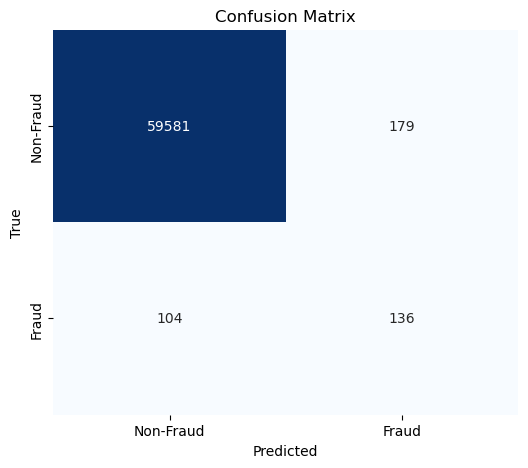


Classification Report:
              precision    recall  f1-score   support

           0     0.9983    0.9970    0.9976     59760
           1     0.4317    0.5667    0.4901       240

    accuracy                         0.9953     60000
   macro avg     0.7150    0.7818    0.7439     60000
weighted avg     0.9960    0.9953    0.9956     60000

(60000,)
(60000,)
(60000, 16)
Standardized mean difference of non-fraud gender:  -0.011749685493841998
Adverse Impact Ratio of non-fraud for gender:  1.0008572894430194
Adverse Impact Ratio of accuracy for gender:  0.9999409415531568
BEST PARAMS SINCE NOW:
BEST VAL AUC:  0.6567275493469814
{'alpha': [1, 2], 'batch_size': 128, 'class_weights': {0: 0.5023592945440193, 1: 106.4638783269962}, 'dropout': 0.0, 'gamma': 0, 'l1_reg': 0.0001, 'l2_reg': 0.0, 'learning_rate': 5e-05, 'num_blocks_list': 7, 'reduction_rate': 0.75, 'units': 256}


<string>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
Hyperparameter Tuning:  19%|██████████▋                                              | 3/16 [18:32<1:13:53, 341.01s/it]

Training with parameters: {'alpha': [1, 2], 'batch_size': 128, 'class_weights': {0: 0.5023592945440193, 1: 106.4638783269962}, 'dropout': 0.0, 'gamma': 0, 'l1_reg': 0.0, 'l2_reg': 0.001, 'learning_rate': 5e-05, 'num_blocks_list': 7, 'reduction_rate': 0.75, 'units': 256}
Model building...
Custom Focal Loss Params
alpha:  [1, 2]
gamma:  0
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               4352      
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 192)       

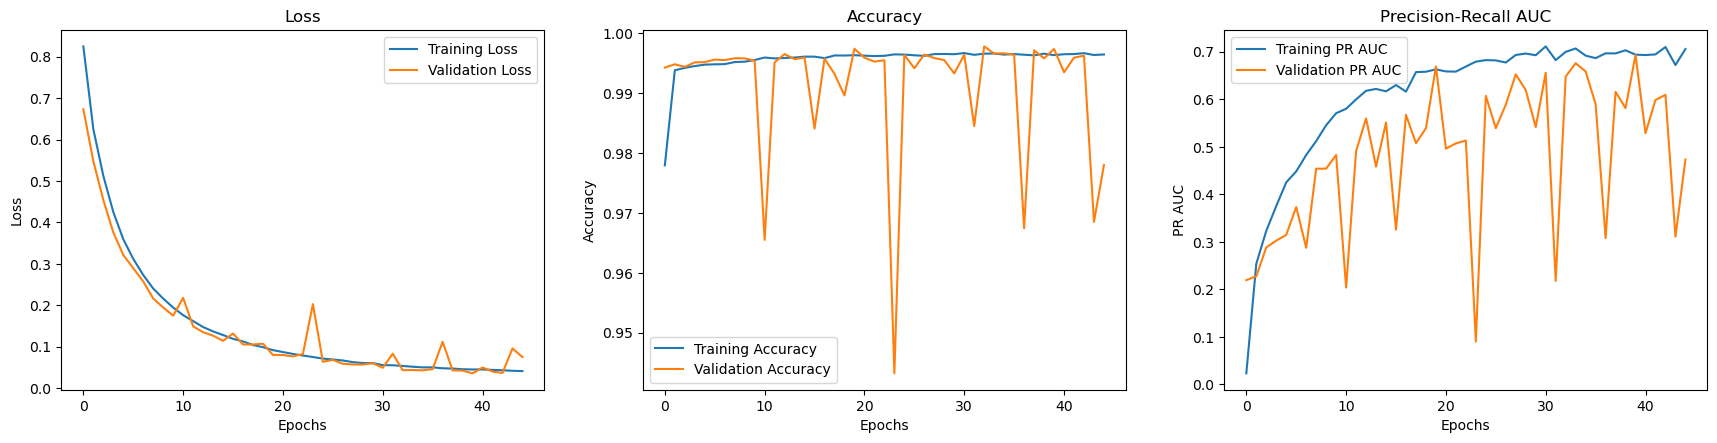

1875/1875 [==============================] - 3s 1ms/step
Accuracy: 0.9974
Precision-Recall AUC Score: 0.6967

Confusion Matrix:
[[59687    73]
 [   85   155]]


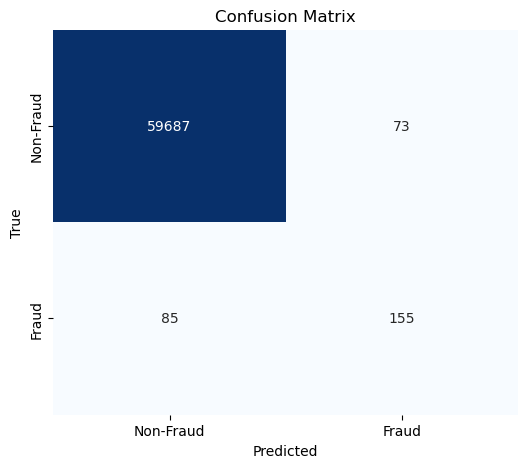


Classification Report:
              precision    recall  f1-score   support

           0     0.9986    0.9988    0.9987     59760
           1     0.6798    0.6458    0.6624       240

    accuracy                         0.9974     60000
   macro avg     0.8392    0.8223    0.8305     60000
weighted avg     0.9973    0.9974    0.9973     60000

(60000,)
(60000,)
(60000, 16)
Standardized mean difference of non-fraud gender:  -0.04195032661392565
Adverse Impact Ratio of non-fraud for gender:  1.0026366805645925
Adverse Impact Ratio of accuracy for gender:  1.0005809323900408
BEST PARAMS SINCE NOW:
BEST VAL AUC:  0.6967499365167763
{'alpha': [1, 2], 'batch_size': 128, 'class_weights': {0: 0.5023592945440193, 1: 106.4638783269962}, 'dropout': 0.0, 'gamma': 0, 'l1_reg': 0.0, 'l2_reg': 0.001, 'learning_rate': 5e-05, 'num_blocks_list': 7, 'reduction_rate': 0.75, 'units': 256}


<string>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
Hyperparameter Tuning:  25%|██████████████▎                                          | 4/16 [30:04<1:35:56, 479.69s/it]

Training with parameters: {'alpha': [1, 2], 'batch_size': 128, 'class_weights': {0: 0.5023592945440193, 1: 106.4638783269962}, 'dropout': 0.0, 'gamma': 0.1, 'l1_reg': 0.001, 'l2_reg': 0.0, 'learning_rate': 5e-05, 'num_blocks_list': 7, 'reduction_rate': 0.75, 'units': 256}
Model building...
Custom Focal Loss Params
alpha:  [1, 2]
gamma:  0.1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               4352      
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 192)   

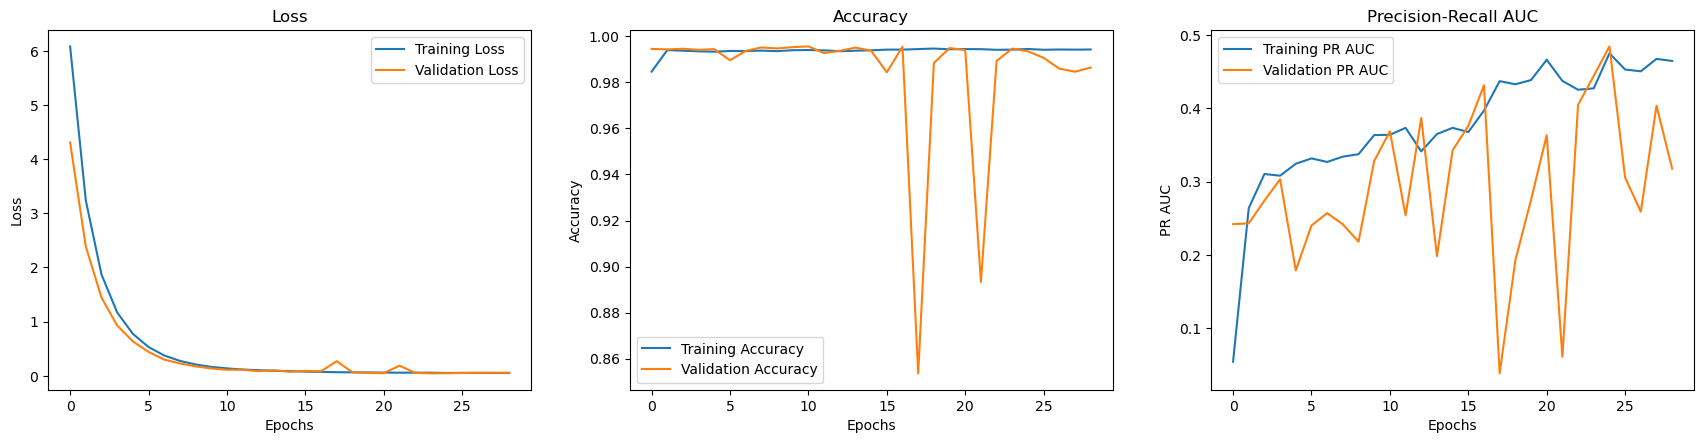

1875/1875 [==============================] - 3s 2ms/step
Accuracy: 0.9947
Precision-Recall AUC Score: 0.4495

Confusion Matrix:
[[59521   239]
 [   80   160]]


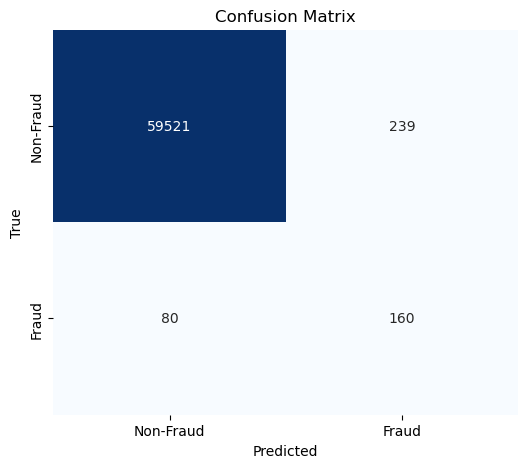


Classification Report:
              precision    recall  f1-score   support

           0     0.9987    0.9960    0.9973     59760
           1     0.4010    0.6667    0.5008       240

    accuracy                         0.9947     60000
   macro avg     0.6998    0.8313    0.7491     60000
weighted avg     0.9963    0.9947    0.9953     60000

(60000,)
(60000,)
(60000, 16)
Standardized mean difference of non-fraud gender:  -0.02115755634766102
Adverse Impact Ratio of non-fraud for gender:  1.0017434155328062
Adverse Impact Ratio of accuracy for gender:  0.9995847111127127
BEST PARAMS SINCE NOW:
BEST VAL AUC:  0.6967499365167763
{'alpha': [1, 2], 'batch_size': 128, 'class_weights': {0: 0.5023592945440193, 1: 106.4638783269962}, 'dropout': 0.0, 'gamma': 0, 'l1_reg': 0.0, 'l2_reg': 0.001, 'learning_rate': 5e-05, 'num_blocks_list': 7, 'reduction_rate': 0.75, 'units': 256}


<string>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
Hyperparameter Tuning:  31%|█████████████████▊                                       | 5/16 [38:11<1:28:26, 482.44s/it]

Training with parameters: {'alpha': [1, 2], 'batch_size': 128, 'class_weights': {0: 0.5023592945440193, 1: 106.4638783269962}, 'dropout': 0.0, 'gamma': 0.1, 'l1_reg': 0.001, 'l2_reg': 0.001, 'learning_rate': 5e-05, 'num_blocks_list': 7, 'reduction_rate': 0.75, 'units': 256}
Model building...
Custom Focal Loss Params
alpha:  [1, 2]
gamma:  0.1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               4352      
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 192) 

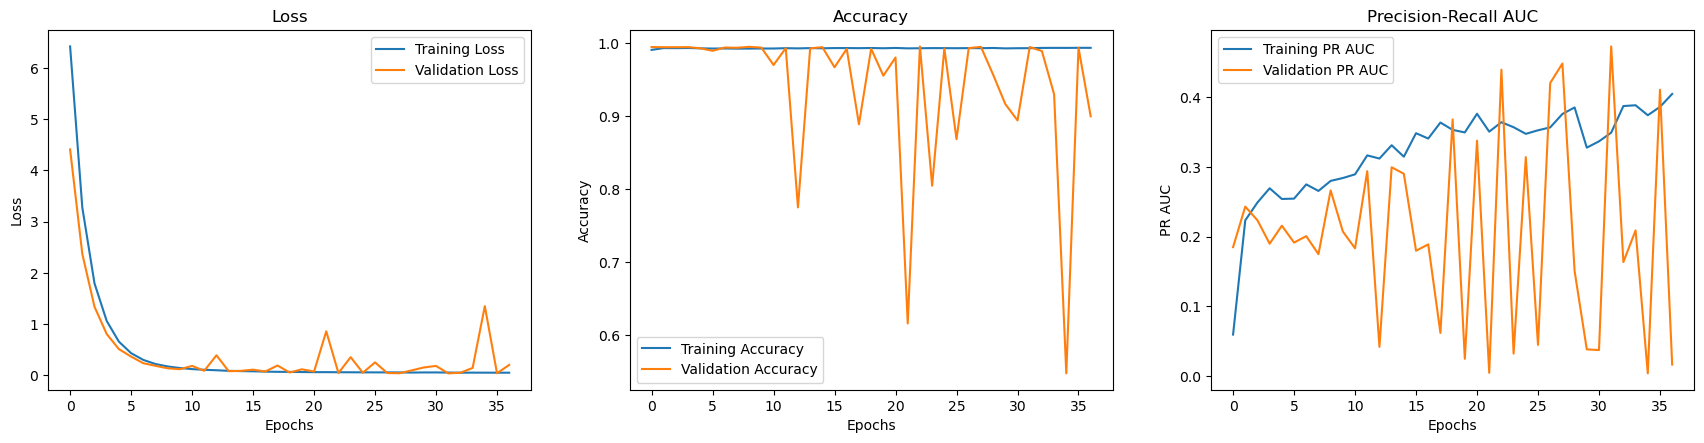

1875/1875 [==============================] - 4s 2ms/step
Accuracy: 0.9950
Precision-Recall AUC Score: 0.4750

Confusion Matrix:
[[59539   221]
 [   79   161]]


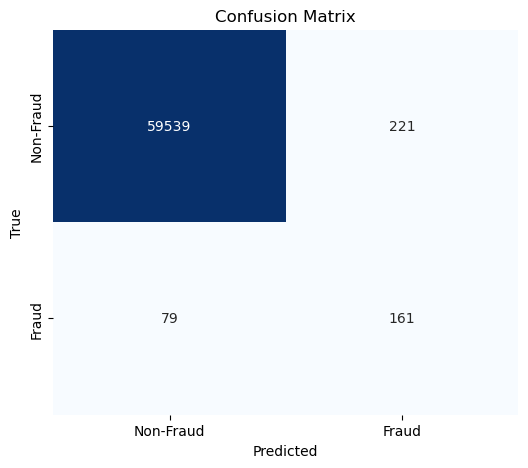


Classification Report:
              precision    recall  f1-score   support

           0     0.9987    0.9963    0.9975     59760
           1     0.4215    0.6708    0.5177       240

    accuracy                         0.9950     60000
   macro avg     0.7101    0.8336    0.7576     60000
weighted avg     0.9964    0.9950    0.9956     60000

(60000,)
(60000,)
(60000, 16)
Standardized mean difference of non-fraud gender:  -0.021348117849320083
Adverse Impact Ratio of non-fraud for gender:  1.0017213041414907
Adverse Impact Ratio of accuracy for gender:  0.9996243991184596
BEST PARAMS SINCE NOW:
BEST VAL AUC:  0.6967499365167763
{'alpha': [1, 2], 'batch_size': 128, 'class_weights': {0: 0.5023592945440193, 1: 106.4638783269962}, 'dropout': 0.0, 'gamma': 0, 'l1_reg': 0.0, 'l2_reg': 0.001, 'learning_rate': 5e-05, 'num_blocks_list': 7, 'reduction_rate': 0.75, 'units': 256}


<string>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
Hyperparameter Tuning:  38%|█████████████████████▍                                   | 6/16 [48:03<1:26:37, 519.73s/it]

Training with parameters: {'alpha': [1, 2], 'batch_size': 128, 'class_weights': {0: 0.5023592945440193, 1: 106.4638783269962}, 'dropout': 0.0, 'gamma': 0.1, 'l1_reg': 0.0, 'l2_reg': 0.0, 'learning_rate': 5e-05, 'num_blocks_list': 7, 'reduction_rate': 0.75, 'units': 256}
Model building...
Custom Focal Loss Params
alpha:  [1, 2]
gamma:  0.1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               4352      
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 192)     

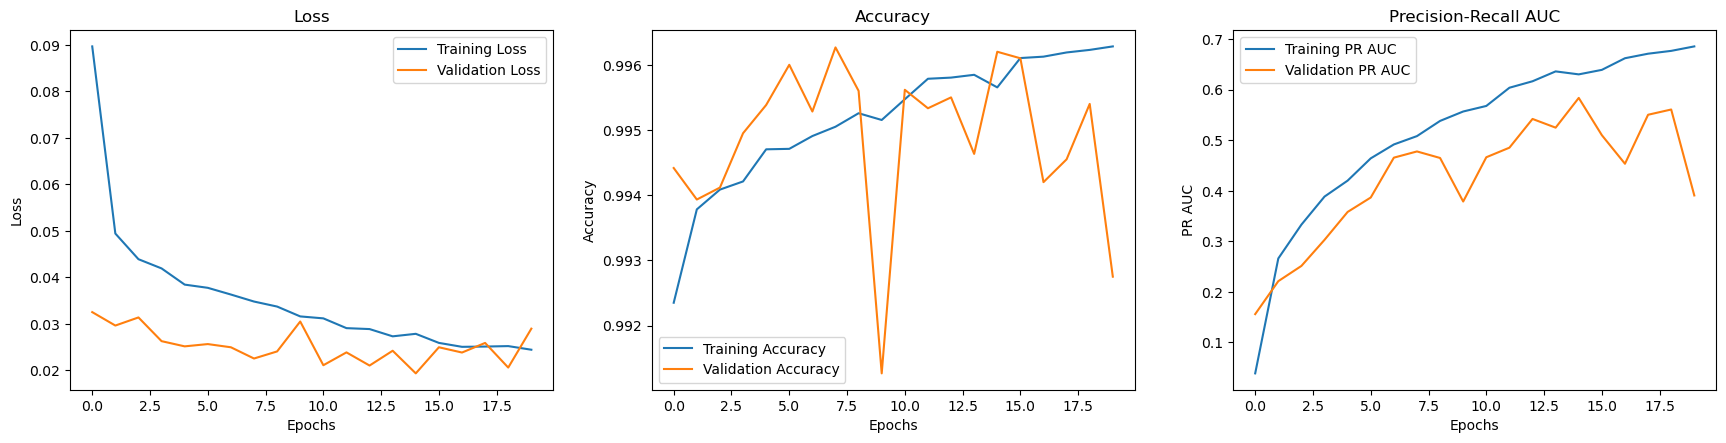

1875/1875 [==============================] - 3s 1ms/step
Accuracy: 0.9962
Precision-Recall AUC Score: 0.5847

Confusion Matrix:
[[59632   128]
 [  100   140]]


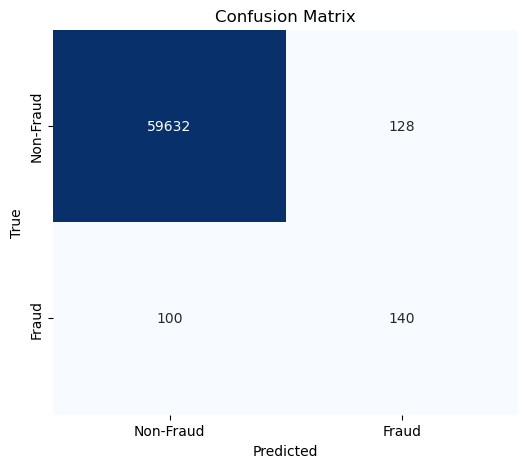


Classification Report:
              precision    recall  f1-score   support

           0     0.9983    0.9979    0.9981     59760
           1     0.5224    0.5833    0.5512       240

    accuracy                         0.9962     60000
   macro avg     0.7604    0.7906    0.7746     60000
weighted avg     0.9964    0.9962    0.9963     60000

(60000,)
(60000,)
(60000, 16)
Standardized mean difference of non-fraud gender:  -0.029859125752648694
Adverse Impact Ratio of non-fraud for gender:  1.0020235450724329
Adverse Impact Ratio of accuracy for gender:  1.0009446797110215
BEST PARAMS SINCE NOW:
BEST VAL AUC:  0.6967499365167763
{'alpha': [1, 2], 'batch_size': 128, 'class_weights': {0: 0.5023592945440193, 1: 106.4638783269962}, 'dropout': 0.0, 'gamma': 0, 'l1_reg': 0.0, 'l2_reg': 0.001, 'learning_rate': 5e-05, 'num_blocks_list': 7, 'reduction_rate': 0.75, 'units': 256}


<string>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
Hyperparameter Tuning:  44%|████████████████████████▉                                | 7/16 [52:23<1:05:13, 434.78s/it]

Training with parameters: {'alpha': [1, 2], 'batch_size': 128, 'class_weights': {0: 0.5023592945440193, 1: 106.4638783269962}, 'dropout': 0.0, 'gamma': 0.1, 'l1_reg': 0.0, 'l2_reg': 0.001, 'learning_rate': 5e-05, 'num_blocks_list': 7, 'reduction_rate': 0.75, 'units': 256}
Model building...
Custom Focal Loss Params
alpha:  [1, 2]
gamma:  0.1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               4352      
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 192)   

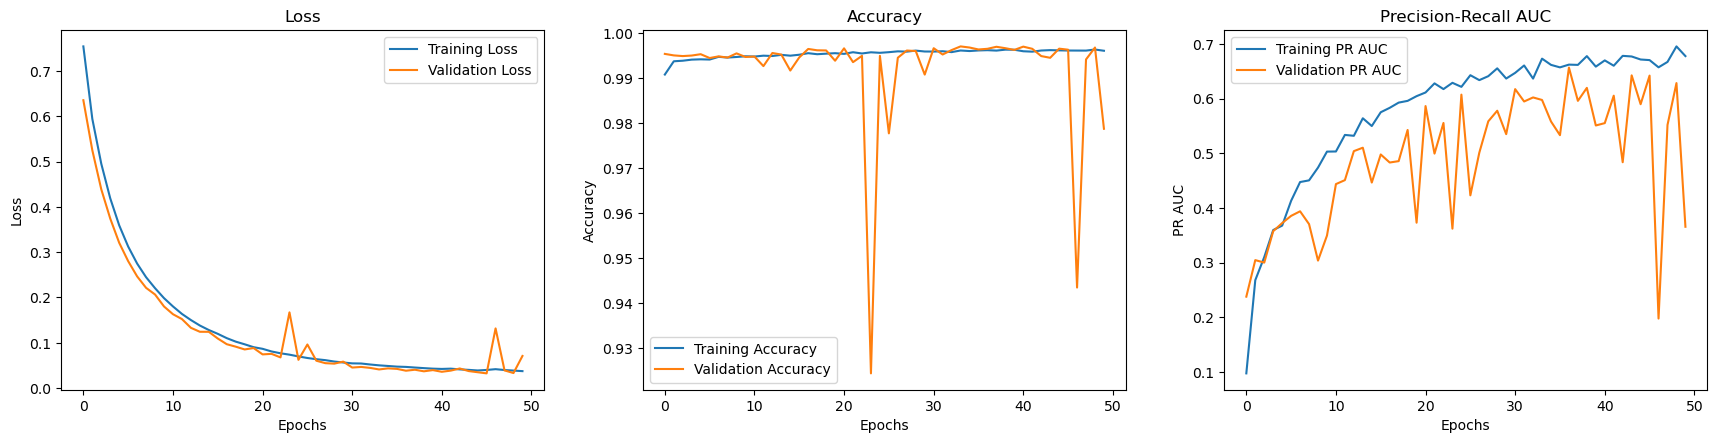

1875/1875 [==============================] - 3s 2ms/step
Accuracy: 0.9787
Precision-Recall AUC Score: 0.3752

Confusion Matrix:
[[58556  1204]
 [   73   167]]


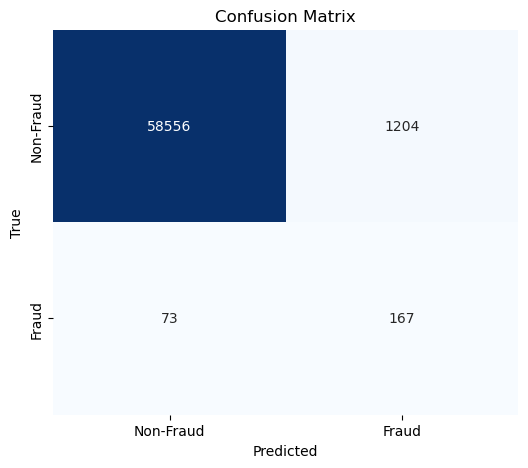


Classification Report:
              precision    recall  f1-score   support

           0     0.9988    0.9799    0.9892     59760
           1     0.1218    0.6958    0.2073       240

    accuracy                         0.9787     60000
   macro avg     0.5603    0.8378    0.5983     60000
weighted avg     0.9952    0.9787    0.9861     60000

(60000,)
(60000,)
(60000, 16)
Standardized mean difference of non-fraud gender:  0.04786835909639227
Adverse Impact Ratio of non-fraud for gender:  0.9927645725438279
Adverse Impact Ratio of accuracy for gender:  0.9906282366304201
BEST PARAMS SINCE NOW:
BEST VAL AUC:  0.6967499365167763
{'alpha': [1, 2], 'batch_size': 128, 'class_weights': {0: 0.5023592945440193, 1: 106.4638783269962}, 'dropout': 0.0, 'gamma': 0, 'l1_reg': 0.0, 'l2_reg': 0.001, 'learning_rate': 5e-05, 'num_blocks_list': 7, 'reduction_rate': 0.75, 'units': 256}


<string>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
Hyperparameter Tuning:  50%|███████████████████████████▌                           | 8/16 [1:04:29<1:10:19, 527.49s/it]

Training with parameters: {'alpha': [1, 2], 'batch_size': 256, 'class_weights': {0: 0.5023592945440193, 1: 106.4638783269962}, 'dropout': 0.0, 'gamma': 0, 'l1_reg': 0.001, 'l2_reg': 0.0, 'learning_rate': 5e-05, 'num_blocks_list': 7, 'reduction_rate': 0.75, 'units': 256}
Model building...
Custom Focal Loss Params
alpha:  [1, 2]
gamma:  0
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               4352      
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 192)       

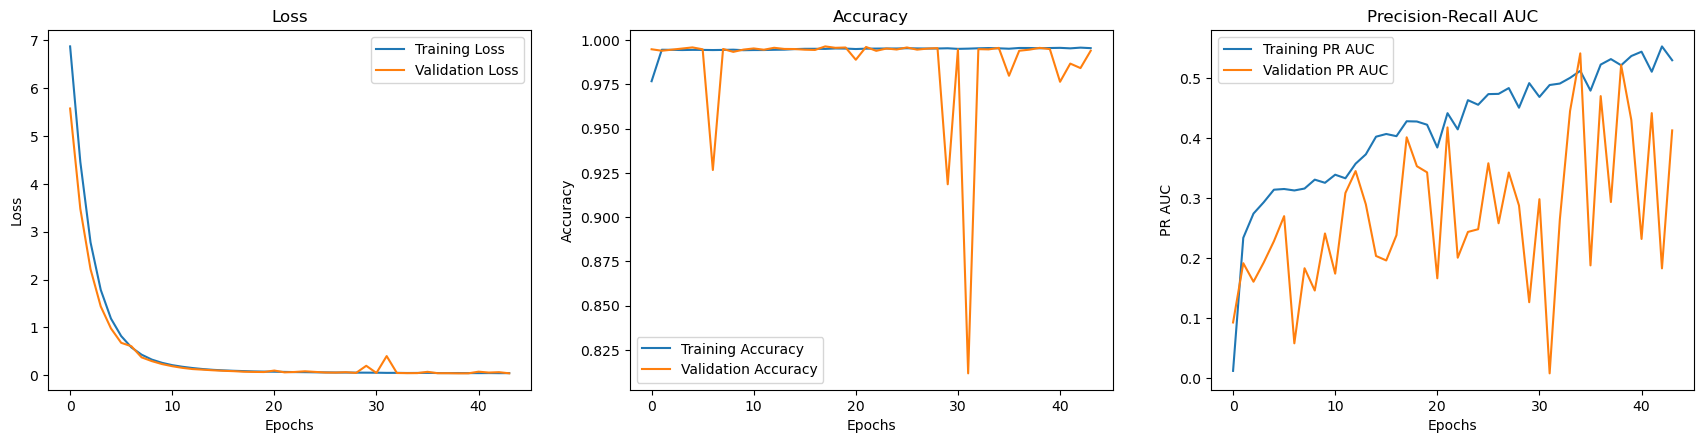

1875/1875 [==============================] - 2s 1ms/step
Accuracy: 0.9955
Precision-Recall AUC Score: 0.5223

Confusion Matrix:
[[59584   176]
 [   93   147]]


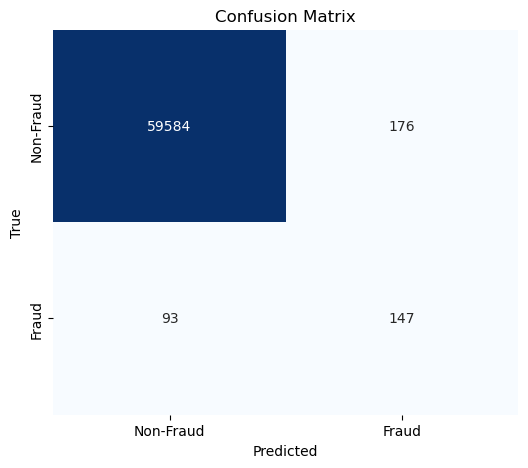


Classification Report:
              precision    recall  f1-score   support

           0     0.9984    0.9971    0.9977     59760
           1     0.4551    0.6125    0.5222       240

    accuracy                         0.9955     60000
   macro avg     0.7268    0.8048    0.7600     60000
weighted avg     0.9963    0.9955    0.9958     60000

(60000,)
(60000,)
(60000, 16)
Standardized mean difference of non-fraud gender:  -0.02377501263244046
Adverse Impact Ratio of non-fraud for gender:  1.001764280696233
Adverse Impact Ratio of accuracy for gender:  1.0000305765430422
BEST PARAMS SINCE NOW:
BEST VAL AUC:  0.6967499365167763
{'alpha': [1, 2], 'batch_size': 128, 'class_weights': {0: 0.5023592945440193, 1: 106.4638783269962}, 'dropout': 0.0, 'gamma': 0, 'l1_reg': 0.0, 'l2_reg': 0.001, 'learning_rate': 5e-05, 'num_blocks_list': 7, 'reduction_rate': 0.75, 'units': 256}


<string>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
Hyperparameter Tuning:  56%|████████████████████████████████                         | 9/16 [1:11:57<58:37, 502.44s/it]

Training with parameters: {'alpha': [1, 2], 'batch_size': 256, 'class_weights': {0: 0.5023592945440193, 1: 106.4638783269962}, 'dropout': 0.0, 'gamma': 0, 'l1_reg': 0.001, 'l2_reg': 0.001, 'learning_rate': 5e-05, 'num_blocks_list': 7, 'reduction_rate': 0.75, 'units': 256}
Model building...
Custom Focal Loss Params
alpha:  [1, 2]
gamma:  0
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               4352      
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 192)     

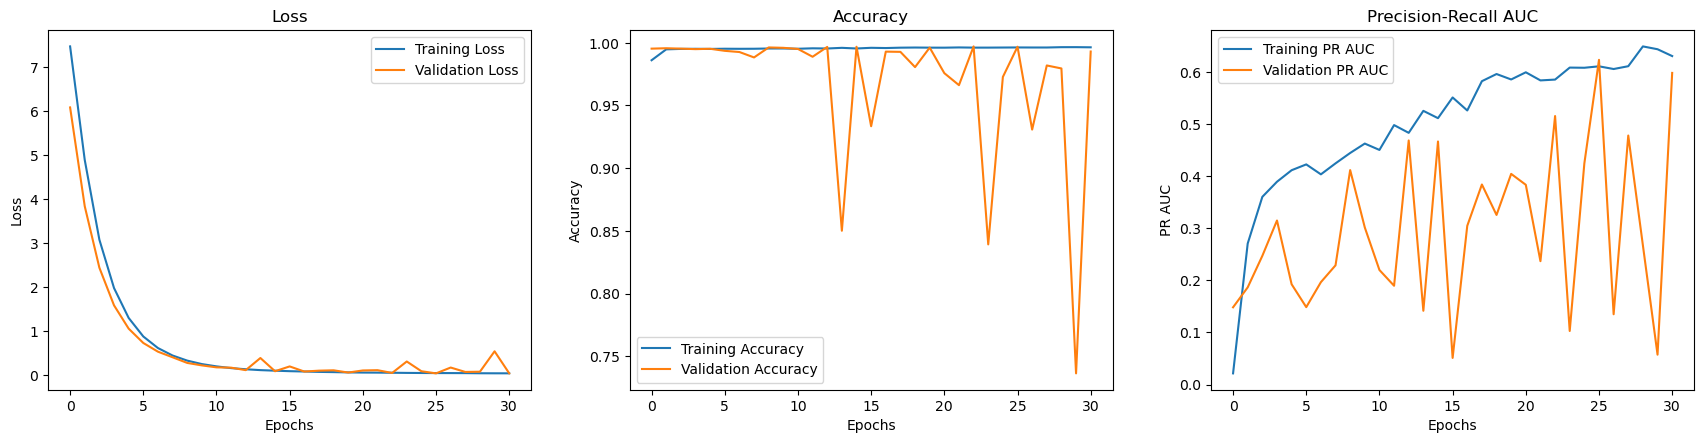

1875/1875 [==============================] - 3s 1ms/step
Accuracy: 0.9969
Precision-Recall AUC Score: 0.6245

Confusion Matrix:
[[59651   109]
 [   79   161]]


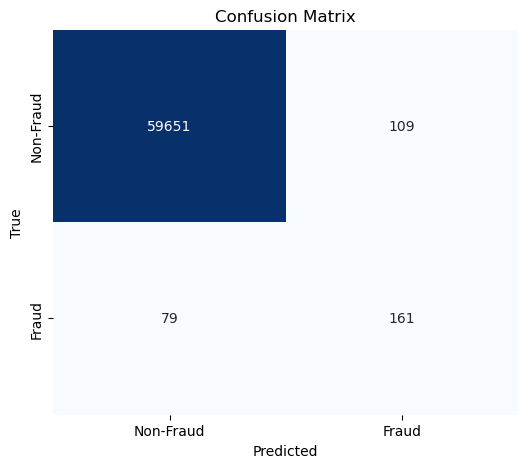


Classification Report:
              precision    recall  f1-score   support

           0     0.9987    0.9982    0.9984     59760
           1     0.5963    0.6708    0.6314       240

    accuracy                         0.9969     60000
   macro avg     0.7975    0.8345    0.8149     60000
weighted avg     0.9971    0.9969    0.9970     60000

(60000,)
(60000,)
(60000, 16)
Standardized mean difference of non-fraud gender:  -0.043565951078684204
Adverse Impact Ratio of non-fraud for gender:  1.0029790651789543
Adverse Impact Ratio of accuracy for gender:  1.0004761633123218
BEST PARAMS SINCE NOW:
BEST VAL AUC:  0.6967499365167763
{'alpha': [1, 2], 'batch_size': 128, 'class_weights': {0: 0.5023592945440193, 1: 106.4638783269962}, 'dropout': 0.0, 'gamma': 0, 'l1_reg': 0.0, 'l2_reg': 0.001, 'learning_rate': 5e-05, 'num_blocks_list': 7, 'reduction_rate': 0.75, 'units': 256}


<string>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
Hyperparameter Tuning:  62%|███████████████████████████████████                     | 10/16 [1:16:56<43:58, 439.80s/it]

Training with parameters: {'alpha': [1, 2], 'batch_size': 256, 'class_weights': {0: 0.5023592945440193, 1: 106.4638783269962}, 'dropout': 0.0, 'gamma': 0, 'l1_reg': 0.0, 'l2_reg': 0.0, 'learning_rate': 5e-05, 'num_blocks_list': 7, 'reduction_rate': 0.75, 'units': 256}
Model building...
Custom Focal Loss Params
alpha:  [1, 2]
gamma:  0
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               4352      
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 192)         

Epoch 25/60
1094/1094 [==============================] - 8s 7ms/step - loss: 0.0198 - accuracy: 0.9969 - pr_auc: 0.7224 - val_loss: 0.0233 - val_accuracy: 0.9967 - val_pr_auc: 0.5566
Epoch 26/60
1094/1094 [==============================] - 8s 8ms/step - loss: 0.0196 - accuracy: 0.9971 - pr_auc: 0.7326 - val_loss: 0.0210 - val_accuracy: 0.9964 - val_pr_auc: 0.5741
Plotting training and validation metrics across epochs


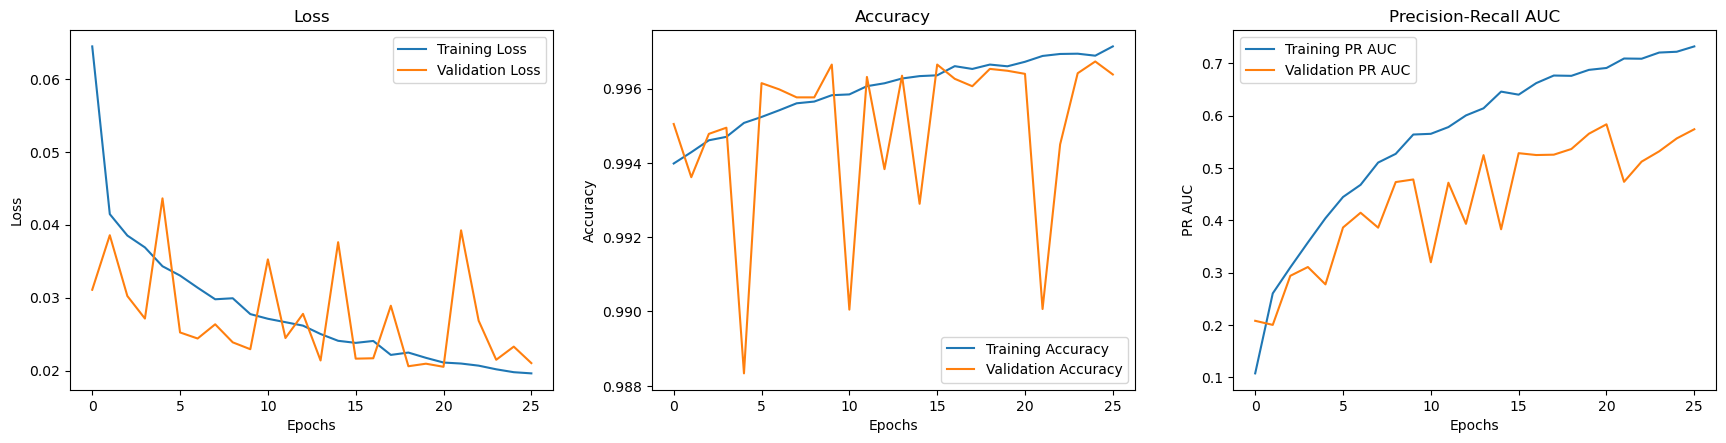

1875/1875 [==============================] - 3s 1ms/step
Accuracy: 0.9964
Precision-Recall AUC Score: 0.5827

Confusion Matrix:
[[59654   106]
 [  110   130]]


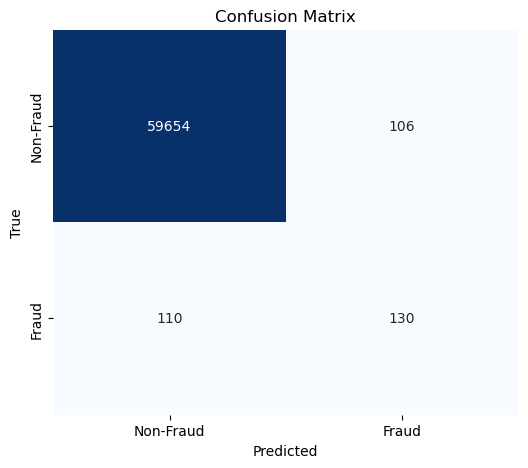


Classification Report:
              precision    recall  f1-score   support

           0     0.9982    0.9982    0.9982     59760
           1     0.5508    0.5417    0.5462       240

    accuracy                         0.9964     60000
   macro avg     0.7745    0.7699    0.7722     60000
weighted avg     0.9964    0.9964    0.9964     60000

(60000,)
(60000,)
(60000, 16)
Standardized mean difference of non-fraud gender:  -0.025936255956910036
Adverse Impact Ratio of non-fraud for gender:  1.001647390403478
Adverse Impact Ratio of accuracy for gender:  1.0004999142456978
BEST PARAMS SINCE NOW:
BEST VAL AUC:  0.6967499365167763
{'alpha': [1, 2], 'batch_size': 128, 'class_weights': {0: 0.5023592945440193, 1: 106.4638783269962}, 'dropout': 0.0, 'gamma': 0, 'l1_reg': 0.0, 'l2_reg': 0.001, 'learning_rate': 5e-05, 'num_blocks_list': 7, 'reduction_rate': 0.75, 'units': 256}


<string>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
Hyperparameter Tuning:  69%|██████████████████████████████████████▌                 | 11/16 [1:20:41<31:10, 374.01s/it]

Training with parameters: {'alpha': [1, 2], 'batch_size': 256, 'class_weights': {0: 0.5023592945440193, 1: 106.4638783269962}, 'dropout': 0.0, 'gamma': 0, 'l1_reg': 0.0, 'l2_reg': 0.001, 'learning_rate': 5e-05, 'num_blocks_list': 7, 'reduction_rate': 0.75, 'units': 256}
Model building...
Custom Focal Loss Params
alpha:  [1, 2]
gamma:  0
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               4352      
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 192)       

Epoch 25/60
1094/1094 [==============================] - 9s 8ms/step - loss: 0.0808 - accuracy: 0.9965 - pr_auc: 0.6714 - val_loss: 0.0748 - val_accuracy: 0.9972 - val_pr_auc: 0.6355
Epoch 26/60
1094/1094 [==============================] - 9s 8ms/step - loss: 0.0771 - accuracy: 0.9965 - pr_auc: 0.6767 - val_loss: 0.0838 - val_accuracy: 0.9923 - val_pr_auc: 0.5241
Epoch 27/60
1094/1094 [==============================] - 9s 9ms/step - loss: 0.0744 - accuracy: 0.9966 - pr_auc: 0.6696 - val_loss: 0.0726 - val_accuracy: 0.9956 - val_pr_auc: 0.5466
Epoch 28/60
1094/1094 [==============================] - 10s 9ms/step - loss: 0.0708 - accuracy: 0.9967 - pr_auc: 0.6873 - val_loss: 0.0799 - val_accuracy: 0.9912 - val_pr_auc: 0.4861
Epoch 29/60
1094/1094 [==============================] - 10s 9ms/step - loss: 0.0689 - accuracy: 0.9966 - pr_auc: 0.6835 - val_loss: 0.0693 - val_accuracy: 0.9951 - val_pr_auc: 0.5313
Epoch 30/60
1094/1094 [==============================] - 10s 9ms/step - loss: 0.066

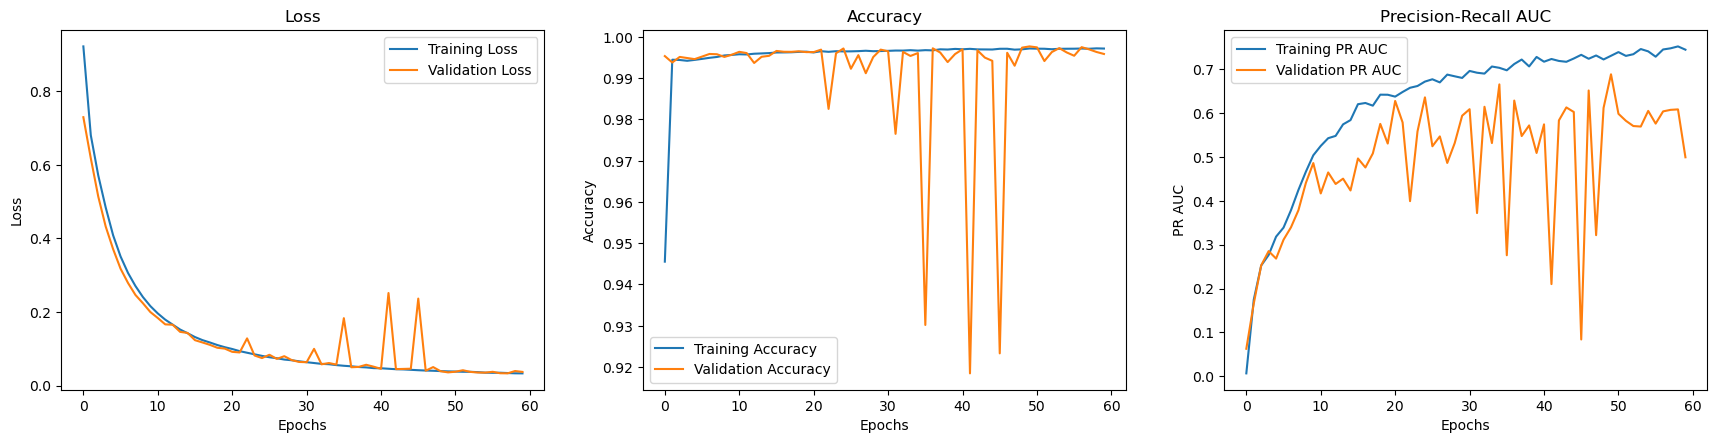

1875/1875 [==============================] - 3s 1ms/step
Accuracy: 0.9959
Precision-Recall AUC Score: 0.5034

Confusion Matrix:
[[59607   153]
 [   94   146]]


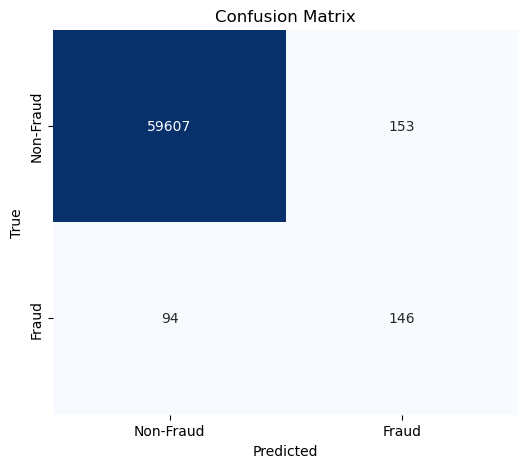


Classification Report:
              precision    recall  f1-score   support

           0     0.9984    0.9974    0.9979     59760
           1     0.4883    0.6083    0.5417       240

    accuracy                         0.9959     60000
   macro avg     0.7434    0.8029    0.7698     60000
weighted avg     0.9964    0.9959    0.9961     60000

(60000,)
(60000,)
(60000, 16)
Standardized mean difference of non-fraud gender:  -0.0008567888387616086
Adverse Impact Ratio of non-fraud for gender:  1.0000606539292964
Adverse Impact Ratio of accuracy for gender:  0.9988110938058868
BEST PARAMS SINCE NOW:
BEST VAL AUC:  0.6967499365167763
{'alpha': [1, 2], 'batch_size': 128, 'class_weights': {0: 0.5023592945440193, 1: 106.4638783269962}, 'dropout': 0.0, 'gamma': 0, 'l1_reg': 0.0, 'l2_reg': 0.001, 'learning_rate': 5e-05, 'num_blocks_list': 7, 'reduction_rate': 0.75, 'units': 256}


<string>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
Hyperparameter Tuning:  75%|██████████████████████████████████████████              | 12/16 [1:29:55<28:35, 428.75s/it]

Training with parameters: {'alpha': [1, 2], 'batch_size': 256, 'class_weights': {0: 0.5023592945440193, 1: 106.4638783269962}, 'dropout': 0.0, 'gamma': 0.1, 'l1_reg': 0.001, 'l2_reg': 0.0, 'learning_rate': 5e-05, 'num_blocks_list': 7, 'reduction_rate': 0.75, 'units': 256}
Model building...
Custom Focal Loss Params
alpha:  [1, 2]
gamma:  0.1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               4352      
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 192)   

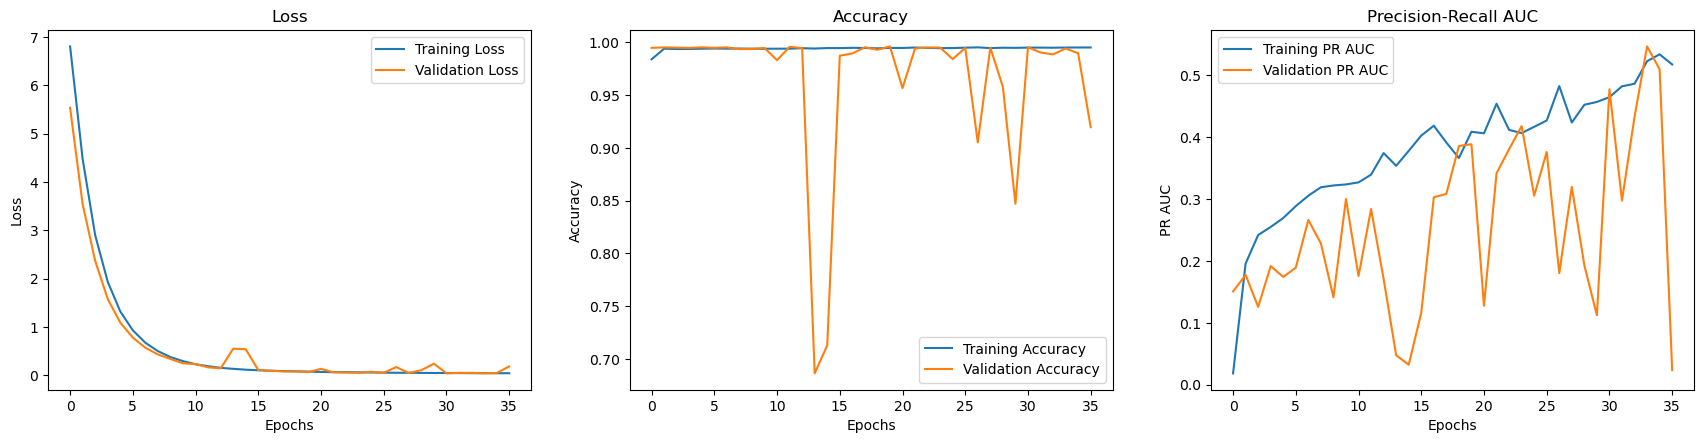

1875/1875 [==============================] - 3s 1ms/step
Accuracy: 0.9955
Precision-Recall AUC Score: 0.4800

Confusion Matrix:
[[59575   185]
 [   87   153]]


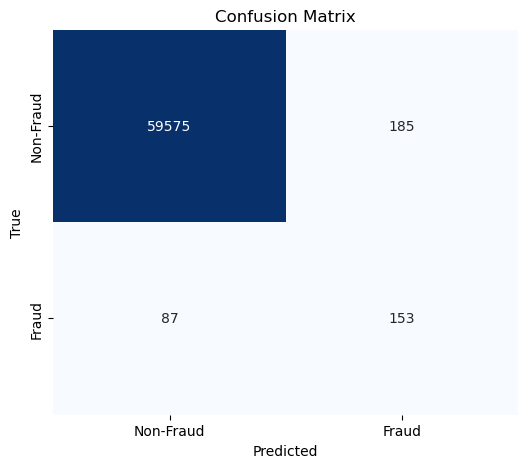


Classification Report:
              precision    recall  f1-score   support

           0     0.9985    0.9969    0.9977     59760
           1     0.4527    0.6375    0.5294       240

    accuracy                         0.9955     60000
   macro avg     0.7256    0.8172    0.7636     60000
weighted avg     0.9964    0.9955    0.9958     60000

(60000,)
(60000,)
(60000, 16)
Standardized mean difference of non-fraud gender:  -0.032285034212370084
Adverse Impact Ratio of non-fraud for gender:  1.0024580861005123
Adverse Impact Ratio of accuracy for gender:  1.0005474847771199
BEST PARAMS SINCE NOW:
BEST VAL AUC:  0.6967499365167763
{'alpha': [1, 2], 'batch_size': 128, 'class_weights': {0: 0.5023592945440193, 1: 106.4638783269962}, 'dropout': 0.0, 'gamma': 0, 'l1_reg': 0.0, 'l2_reg': 0.001, 'learning_rate': 5e-05, 'num_blocks_list': 7, 'reduction_rate': 0.75, 'units': 256}


<string>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
Hyperparameter Tuning:  81%|█████████████████████████████████████████████▌          | 13/16 [1:35:43<20:13, 404.40s/it]

Training with parameters: {'alpha': [1, 2], 'batch_size': 256, 'class_weights': {0: 0.5023592945440193, 1: 106.4638783269962}, 'dropout': 0.0, 'gamma': 0.1, 'l1_reg': 0.001, 'l2_reg': 0.001, 'learning_rate': 5e-05, 'num_blocks_list': 7, 'reduction_rate': 0.75, 'units': 256}
Model building...
Custom Focal Loss Params
alpha:  [1, 2]
gamma:  0.1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               4352      
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 192) 

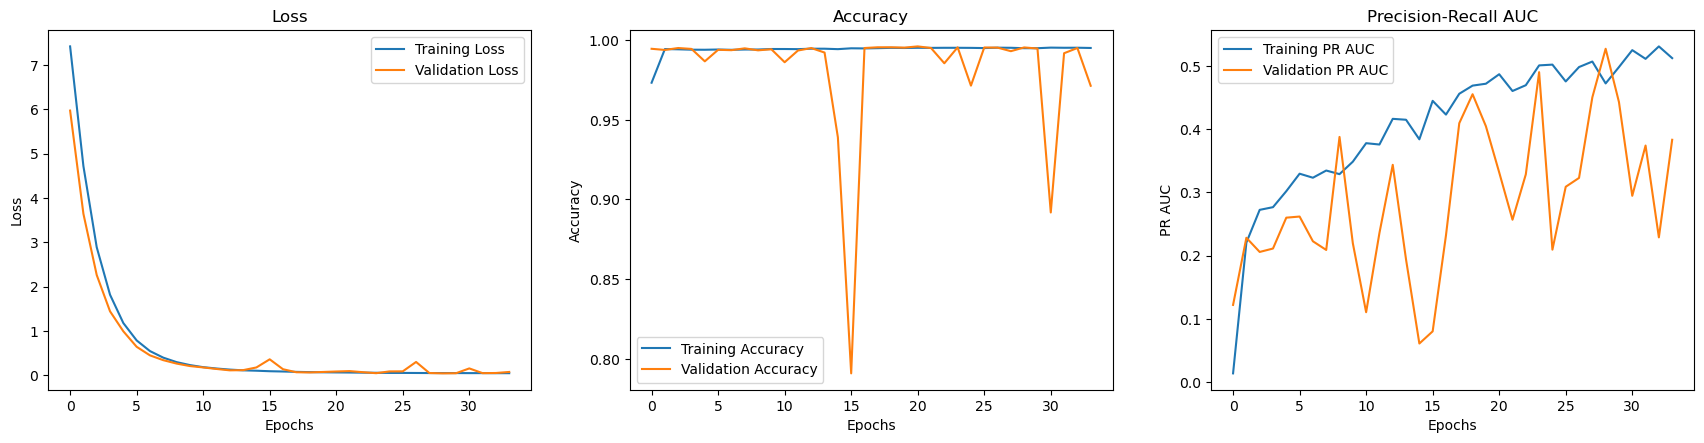

1875/1875 [==============================] - 3s 2ms/step
Accuracy: 0.9954
Precision-Recall AUC Score: 0.5288

Confusion Matrix:
[[59578   182]
 [   94   146]]


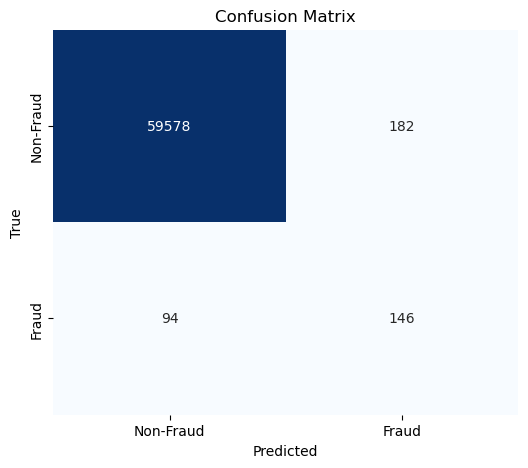


Classification Report:
              precision    recall  f1-score   support

           0     0.9984    0.9970    0.9977     59760
           1     0.4451    0.6083    0.5141       240

    accuracy                         0.9954     60000
   macro avg     0.7218    0.8026    0.7559     60000
weighted avg     0.9962    0.9954    0.9958     60000

(60000,)
(60000,)
(60000, 16)
Standardized mean difference of non-fraud gender:  -0.017959697457914193
Adverse Impact Ratio of non-fraud for gender:  1.0013402031780438
Adverse Impact Ratio of accuracy for gender:  0.9996816111618829
BEST PARAMS SINCE NOW:
BEST VAL AUC:  0.6967499365167763
{'alpha': [1, 2], 'batch_size': 128, 'class_weights': {0: 0.5023592945440193, 1: 106.4638783269962}, 'dropout': 0.0, 'gamma': 0, 'l1_reg': 0.0, 'l2_reg': 0.001, 'learning_rate': 5e-05, 'num_blocks_list': 7, 'reduction_rate': 0.75, 'units': 256}


<string>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
Hyperparameter Tuning:  88%|█████████████████████████████████████████████████       | 14/16 [1:41:36<12:57, 388.66s/it]

Training with parameters: {'alpha': [1, 2], 'batch_size': 256, 'class_weights': {0: 0.5023592945440193, 1: 106.4638783269962}, 'dropout': 0.0, 'gamma': 0.1, 'l1_reg': 0.0, 'l2_reg': 0.0, 'learning_rate': 5e-05, 'num_blocks_list': 7, 'reduction_rate': 0.75, 'units': 256}
Model building...
Custom Focal Loss Params
alpha:  [1, 2]
gamma:  0.1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               4352      
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 192)     

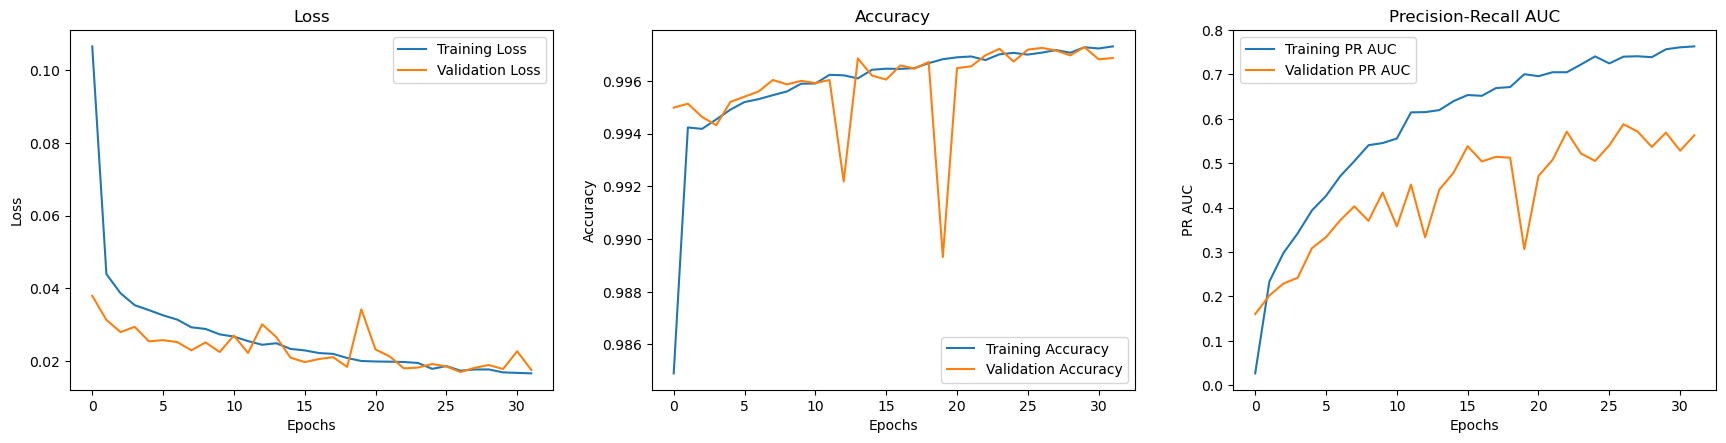

1875/1875 [==============================] - 2s 1ms/step
Accuracy: 0.9972
Precision-Recall AUC Score: 0.5938

Confusion Matrix:
[[59684    76]
 [   89   151]]


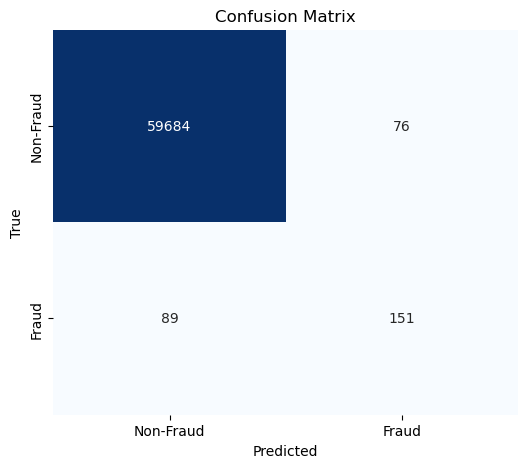


Classification Report:
              precision    recall  f1-score   support

           0     0.9985    0.9987    0.9986     59760
           1     0.6652    0.6292    0.6467       240

    accuracy                         0.9972     60000
   macro avg     0.8319    0.8139    0.8227     60000
weighted avg     0.9972    0.9972    0.9972     60000

(60000,)
(60000,)
(60000, 16)
Standardized mean difference of non-fraud gender:  -0.03720212337356024
Adverse Impact Ratio of non-fraud for gender:  1.0023285892156204
Adverse Impact Ratio of accuracy for gender:  1.0008401118796326
BEST PARAMS SINCE NOW:
BEST VAL AUC:  0.6967499365167763
{'alpha': [1, 2], 'batch_size': 128, 'class_weights': {0: 0.5023592945440193, 1: 106.4638783269962}, 'dropout': 0.0, 'gamma': 0, 'l1_reg': 0.0, 'l2_reg': 0.001, 'learning_rate': 5e-05, 'num_blocks_list': 7, 'reduction_rate': 0.75, 'units': 256}


<string>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
Hyperparameter Tuning:  94%|████████████████████████████████████████████████████▌   | 15/16 [1:46:45<06:04, 364.66s/it]

Training with parameters: {'alpha': [1, 2], 'batch_size': 256, 'class_weights': {0: 0.5023592945440193, 1: 106.4638783269962}, 'dropout': 0.0, 'gamma': 0.1, 'l1_reg': 0.0, 'l2_reg': 0.001, 'learning_rate': 5e-05, 'num_blocks_list': 7, 'reduction_rate': 0.75, 'units': 256}
Model building...
Custom Focal Loss Params
alpha:  [1, 2]
gamma:  0.1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               4352      
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 192)   

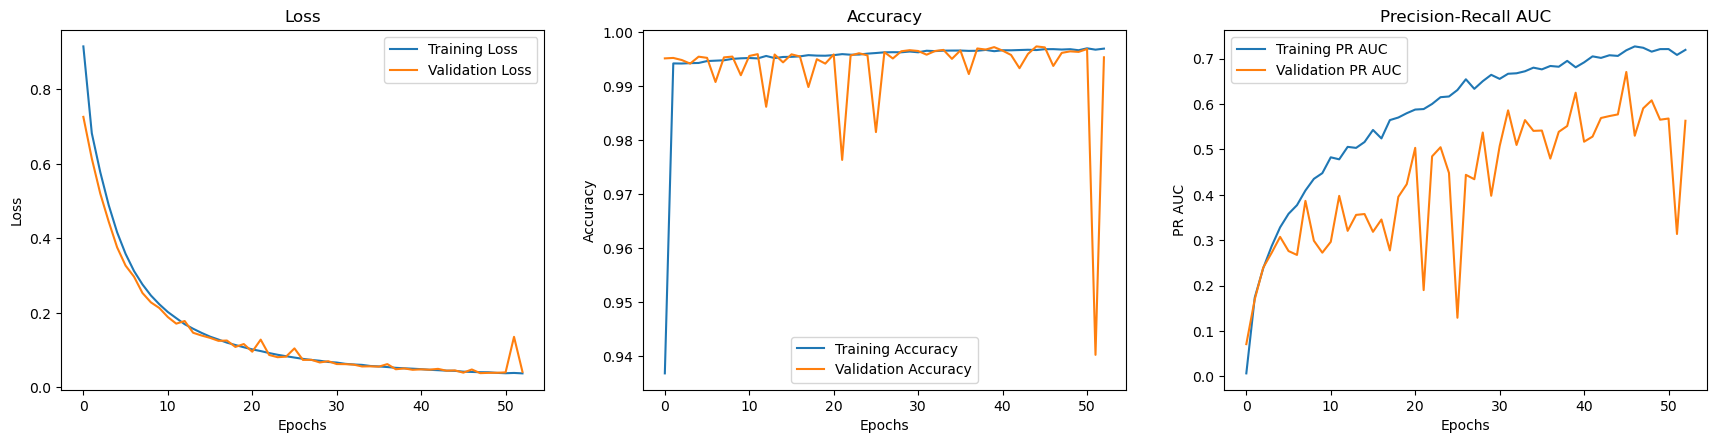

1875/1875 [==============================] - 3s 1ms/step
Accuracy: 0.9961
Precision-Recall AUC Score: 0.5992

Confusion Matrix:
[[59607   153]
 [   78   162]]


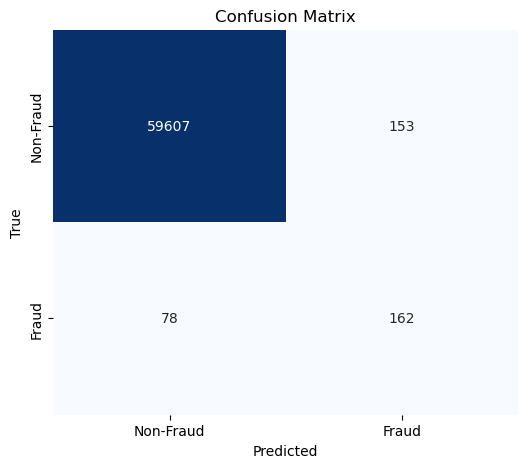


Classification Report:
              precision    recall  f1-score   support

           0     0.9987    0.9974    0.9981     59760
           1     0.5143    0.6750    0.5838       240

    accuracy                         0.9961     60000
   macro avg     0.7565    0.8362    0.7909     60000
weighted avg     0.9968    0.9961    0.9964     60000

(60000,)
(60000,)
(60000, 16)
Standardized mean difference of non-fraud gender:  -0.02646394317026852
Adverse Impact Ratio of non-fraud for gender:  1.001941283771471
Adverse Impact Ratio of accuracy for gender:  0.9997718859333081
BEST PARAMS SINCE NOW:
BEST VAL AUC:  0.6967499365167763
{'alpha': [1, 2], 'batch_size': 128, 'class_weights': {0: 0.5023592945440193, 1: 106.4638783269962}, 'dropout': 0.0, 'gamma': 0, 'l1_reg': 0.0, 'l2_reg': 0.001, 'learning_rate': 5e-05, 'num_blocks_list': 7, 'reduction_rate': 0.75, 'units': 256}


<string>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
Hyperparameter Tuning: 100%|████████████████████████████████████████████████████████| 16/16 [1:55:11<00:00, 431.98s/it]

Best Hyperparameters: {'alpha': [1, 2], 'batch_size': 128, 'class_weights': {0: 0.5023592945440193, 1: 106.4638783269962}, 'dropout': 0.0, 'gamma': 0, 'l1_reg': 0.0, 'l2_reg': 0.001, 'learning_rate': 5e-05, 'num_blocks_list': 7, 'reduction_rate': 0.75, 'units': 256}
Best Validation AUC: 0.6967


In [46]:
# Create the model
# This approach add complexity because we have to optimise two new hyperparameters: alpha and gamma



# Define hyperparameters to tune
param_grid = {
    'gamma': [0, 0.1],  # --> let's try also 0.9, 1.0001, 1.001
    'alpha': [[1, 2]],
    'num_blocks_list': [7],
    'units': [256],
    'reduction_rate': [0.75],
    'l1_reg': [0.001, 0.0], 
    'l2_reg': [0.0, 0.001], 
    'dropout': [0.0],
    'learning_rate': [0.00005],
    'batch_size': [128, 256],
    'class_weights': [
        class_weights,
        #{0: 1.0, 1: 0.5},  # Example custom weighting
    ]
}

# Create combinations of hyperparameters
param_combinations = list(ParameterGrid(param_grid))



with tqdm(total=len(param_combinations), desc="Hyperparameter Tuning") as pbar:
    # Iterate through all parameter combinations
    for params in param_combinations:
        print(f"Training with parameters: {params}")

        # Create the model with the current hyperparameters
        model, hyperparams = create_FFN(
            input_dim=X_train.shape[1],
            num_blocks=params['num_blocks_list'],
            initial_units=params['units'],
            reduction_rate = params['reduction_rate'],
            dropout_rate=params['dropout'],
            activation='relu',
            learning_rate=params['learning_rate'],
            l1_reg=params['l1_reg'], 
            l2_reg=params['l2_reg'],
            custom_focal_loss=True, 
            alpha=params['alpha'], 
            gamma=params['gamma'] 
        )

        # Early stopping to prevent overfitting
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=5, restore_best_weights=True
        )
        
        if params['batch_size'] > 128:
            epochs = 60
        else:
            epochs = 50

        # Train the model
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=params['batch_size'],
            class_weight=params['class_weights'],
            callbacks=[early_stopping]
        )

        print("Plotting training and validation metrics across epochs")
        plot_performance(history)
        
        # Evaluate AUC on the validation set
        y_val_pred = model.predict(X_val)
        y_val_pred_classes = (y_val_pred > 0.5).astype(int)
        
        # Compute main scores
        val_accuracy, val_auc, val_recall, val_f1, val_precision = compute_main_scores(
            y_val, y_val_pred_classes, y_val_pred
        )
        
        # Fairness evaluation
        integrated_df_test, smd_test, air_outcome_test, air_out_accuracy_test = fairness_evaluation(
                        model, X_val, y_val, y_val_pred_classes, "gender", 0, 1, 0
        )
        
        # populating validation_performance dict
        validation_performance["model_type"] = "FFN"
        validation_performance["excluded_features"] = []
        validation_performance["alpha"] = params['alpha']
        validation_performance["gamma"] = params['gamma']
        validation_performance["num_blocks_list"] = params['num_blocks_list']
        validation_performance["units"] = params['units']
        validation_performance["reduction_rate"] = params['reduction_rate']
        validation_performance["l1_reg"] = params['l1_reg']
        validation_performance["l2_reg"] = params['l2_reg']
        validation_performance["dropout"] = params['dropout']
        validation_performance["learning_rate"] = params['learning_rate']
        validation_performance["batch_size"] = params['batch_size']
        validation_performance["class_weights"] = params['class_weights']
        validation_performance["val_precision"] = val_precision
        validation_performance["val_recall"] = val_recall
        validation_performance["val_f1"] = val_f1
        validation_performance["val_accuracy"] = val_accuracy
        validation_performance["val_auc"] = val_auc
        validation_performance["val_aic"] = air_outcome_test
        validation_performance["val_smd"] = smd_test


        # Update the best model if the current one is better
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            best_model = model
            best_params = params
        else:
            # Explicitly delete old models to ensure Python's garbage collector can clean them
            del model
        
        print("BEST PARAMS SINCE NOW:")
        print("BEST VAL AUC: ", best_val_auc)
        print(best_params)
        
        # Save the information to the CSV file
        save_validation_info(validation_performance, "FFN_focal_loss_alpha_analysis.csv")
        
        # Clear Keras/TensorFlow Session
        K.clear_session()
        # Force Garbage Collection
        gc.collect()
        
        pbar.update(1)
        
# Output the best hyperparameters and validation AUC
print(f"Best Hyperparameters: {best_params}")
print(f"Best Validation AUC: {best_val_auc:.4f}")



1875/1875 [==============================] - 2s 1ms/step
Best Threshold (Recall >= 0.8 & Max F1-Score): 0.63
Precision: 0.56, Recall: 0.70, F1-Score: 0.62


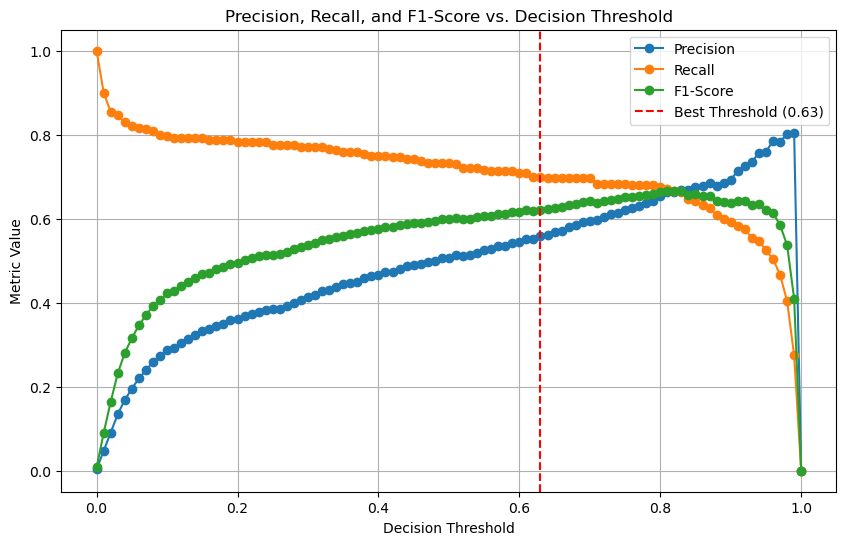

Best Threshold: 0.63
1875/1875 [==============================] - 2s 1ms/step
Accuracy: 0.9968
Precision-Recall AUC Score: 0.7062

Confusion Matrix:
[[59586   131]
 [   59   224]]


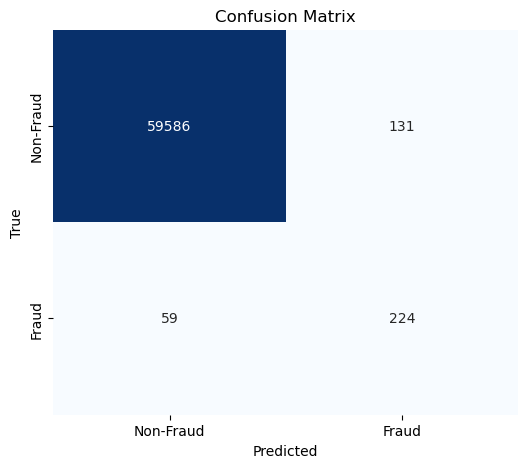


Classification Report:
              precision    recall  f1-score   support

           0     0.9990    0.9978    0.9984     59717
           1     0.6310    0.7915    0.7022       283

    accuracy                         0.9968     60000
   macro avg     0.8150    0.8947    0.8503     60000
weighted avg     0.9973    0.9968    0.9970     60000

Test Metrics:
Accuracy: 0.9968
AUC: 0.7062
Recall: 0.7915
F1 Score: 0.7022
Precision: 0.6310
(60000,)
(60000,)
(60000, 16)
Standardized mean difference of non-fraud gender:  -0.03301956623248863
Adverse Impact Ratio of non-fraud for gender:  1.0025760231076797
Adverse Impact Ratio of accuracy for gender:  0.9989781326109921
Experiment data saved to experiment_log_light_dataset_historical_features.csv


<string>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


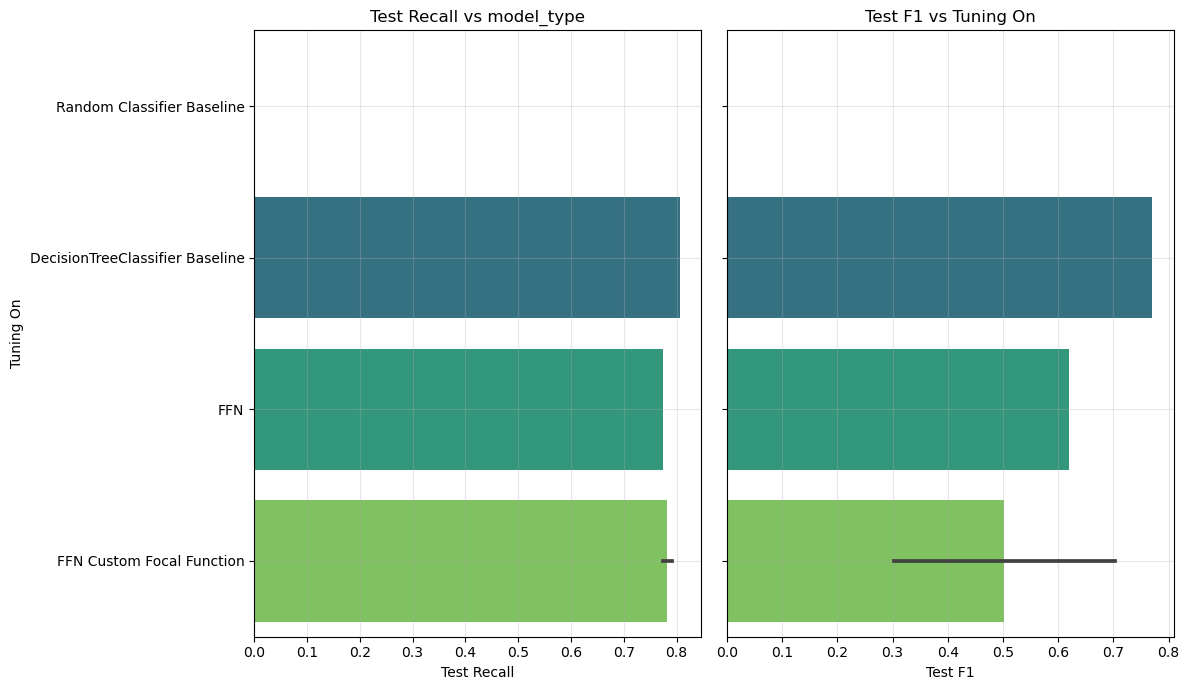

In [35]:


# Evaluate the best model's threshold on the validation set
best_threshold = threshold_metric_evaluation(best_model, X_val, y_val)
print(f"Best Threshold: {best_threshold}")

# Test the best model on the test set
y_test_pred = best_model.predict(X_test)
y_test_pred_classes = (y_test_pred >= best_threshold).astype(int)

# Compute main scores
test_accuracy, test_auc, test_recall, test_f1, test_precision = compute_main_scores(
    y_test, y_test_pred_classes, y_test_pred
)

# Print test evaluation metrics
print("Test Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"AUC: {test_auc:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print(f"Precision: {test_precision:.4f}")

# Fairness evaluation
integrated_df_test, smd_test, air_outcome_test, air_out_accuracy_test = fairness_evaluation(
    best_model, X_test, y_test, y_test_pred_classes, "gender", 0, 1, 0
)


experiment_data = {
    "model_type": f"FFN Custom Focal Function",
    "note": "FFN Custom Focal Function light dataset with historical features",
    "dataset": "400K",
    "hyperparameters": best_params,
    "excluded_features": [],
    "best_threshold": best_threshold,
    "test_precision": test_precision,
    "test_recall": test_recall,
    "test_f1": test_f1,
    "test_accuracy": test_accuracy,
    "test_auc": test_auc,
    "test_aic": air_outcome_test,
    "test_smd": smd_test,
}

save_experiment_data(experiment_data, csv_path)

compare_test_performance(csv_path)

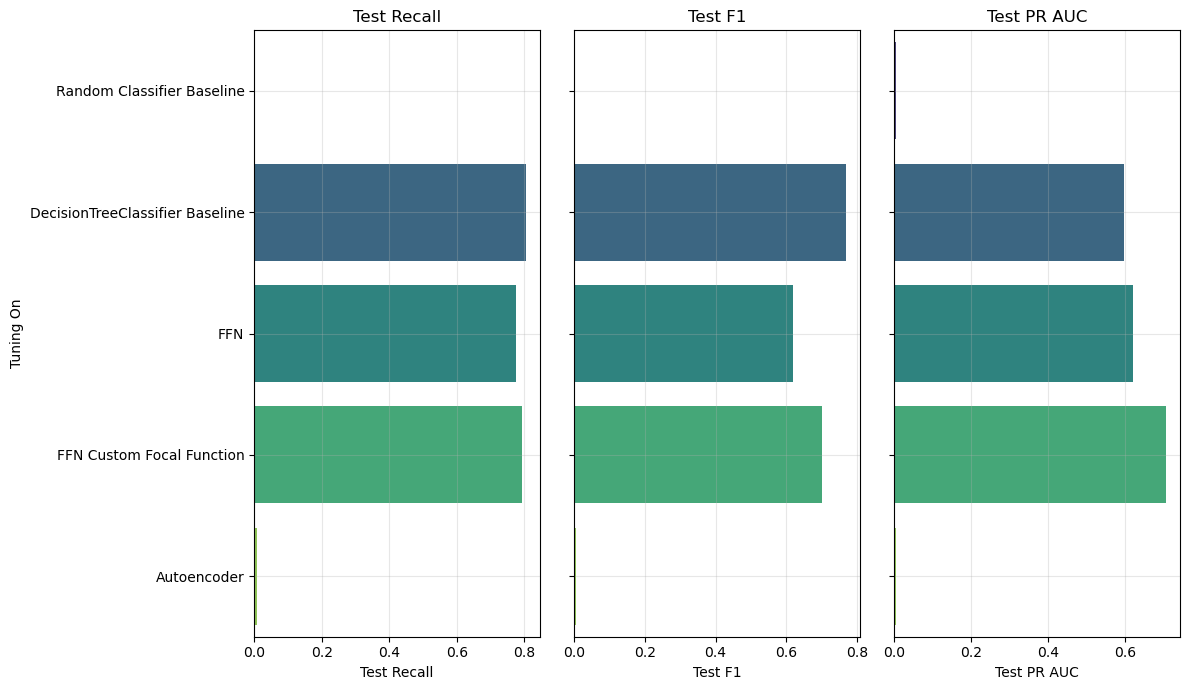

In [48]:
compare_test_performance(csv_path)

# 3 Autoencoder Approach

In [12]:
val_performance = {}
val_performance['hyperparams'] = []
val_performance['val_MSE'] = []

# Initialize variables to track the best model and parameters
best_model = None
best_params = None
best_val_mse = np.inf


X_train_no_fraud.shape : (278685, 16)


Hyperparameter Tuning:   0%|                                                                     | 0/1 [00:00<?, ?it/s]

Training with parameters: {'batch_size': 256, 'dropout': 0.0, 'encoding_dim': 8, 'l1_reg': 0.005, 'l2_reg': 0.0, 'learning_rate': 0.0001}
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 16)]              0         
                                                                 
 dense_10 (Dense)            (None, 8)                 136       
                                                                 
 batch_normalization_8 (Bat  (None, 8)                 32        
 chNormalization)                                                
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 8)                 0         
                                                                 
 dropout_4 (Dropout)         (None, 8)                 0         
                                                     

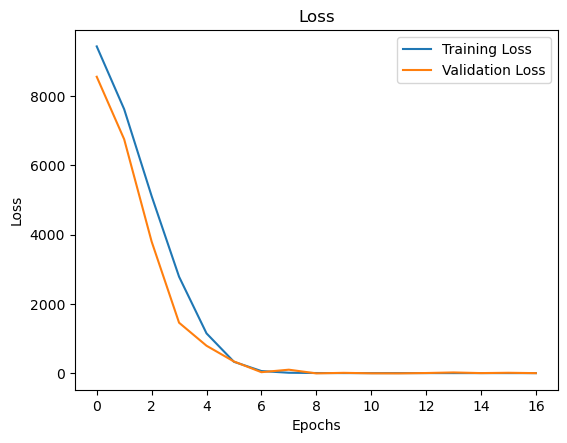

1868/1868 [==============================] - 2s 929us/step


Hyperparameter Tuning: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.33s/it]

Validation MSE: 2.3976
Best Hyperparameters: {'batch_size': 256, 'dropout': 0.0, 'encoding_dim': 8, 'l1_reg': 0.005, 'l2_reg': 0.0, 'learning_rate': 0.0001}
Best Validation MSE: 2.3976


<Axes: title={'center': 'Autoencoder MSE vs Hyperparameter Configurations'}>

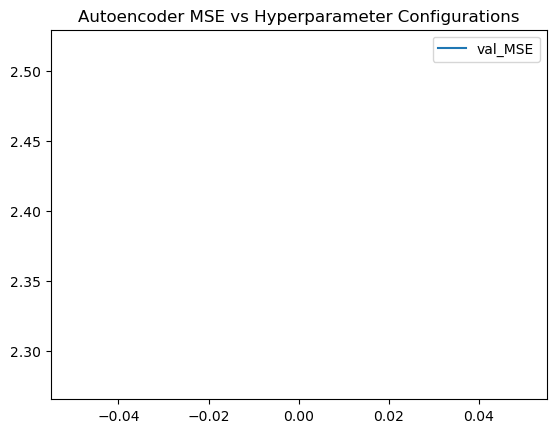

In [13]:
from sklearn.metrics import mean_squared_error

# Removing Fraud 
X_train_no_fraud = X_train[y_train == 0]
X_val_no_fraud = X_val[y_val == 0]

print("X_train_no_fraud.shape :", X_train_no_fraud.shape)


# Define hyperparameters to tune
param_grid = {
    'encoding_dim': [8],
    'l1_reg': [0.005],#[0.0, 0.001, 0.0001], 
    'l2_reg': [0.0],#[0.0, 0.001, 0.0001], 
    'dropout': [0.0], #[0.0, 0.2, 0.3],
    'learning_rate': [0.0001],
    'batch_size': [256], #[64, 128, 256]
}

# (X_train, encoding_dim=6, activation='LeakyReLU', dropout_rate=0.2, learning_rate=0.0001):



# Create combinations of hyperparameters
param_combinations = list(ParameterGrid(param_grid))



with tqdm(total=len(param_combinations), desc="Hyperparameter Tuning") as pbar:
    # Iterate through all parameter combinations
    for params in param_combinations:
        print(f"Training with parameters: {params}")
        
        model, hyperparams = create_autoencoder(X_train_no_fraud, 
                                                      encoding_dim=params['encoding_dim'], 
                                                      activation='LeakyReLU', 
                                                      dropout_rate=params['dropout'],
                                                      learning_rate=params['learning_rate'],
                                                      l1=params['l1_reg'],
                                                      l2=params['l2_reg']
                                                     )
                                                      

        # Compile the autoencoder
        model.compile(optimizer='adam', loss='mse')

        # Early stopping to prevent overfitting
        # patience: Number of epochs with no improvement after which training will be stopped
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # Train the autoencoder
        history = model.fit(
            X_train_no_fraud, X_train_no_fraud,
            epochs=50,
            batch_size=params['batch_size'],
            shuffle=True,
            validation_data=(X_val_no_fraud, X_val_no_fraud),
            callbacks=[early_stopping]
        )


        plot_performance(history)
        # Evaluate MSE on the validation set
        y_val_pred = model.predict(X_val_no_fraud)
        val_mse = mean_squared_error(X_val_no_fraud, y_val_pred)
        print(f"Validation MSE: {val_mse:.4f}")
        val_performance['hyperparams'].append(hyperparams)
        val_performance['val_MSE'].append(val_mse)
        
        # Update the best model if the current one is better
        if val_mse < best_val_mse:
            best_val_mse = val_mse
            best_model = model
            best_params = params
        
        pbar.update(1)


# Output the best hyperparameters and validation AUC
print(f"Best Hyperparameters: {best_params}")
print(f"Best Validation MSE: {best_val_mse:.4f}")
pd.DataFrame(val_performance).plot(title='Autoencoder MSE vs Hyperparameter Configurations')        
        


In [55]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc, f1_score

def find_optimal_threshold(X_val_no_fraud, X_val_fraud, model):
    """
    Computes the optimal threshold for fraud detection using Precision-Recall curves.

    Parameters:
        X_val_no_fraud (numpy array): Validation set with only normal transactions.
        X_val_fraud (numpy array): Validation set with fraud transactions.
        model (tensorflow model): Trained autoencoder model.

    Returns:
        best_threshold (float): The threshold that maximizes the F1-score.
        thresholds (numpy array): Array of tested thresholds.
        f1_scores (numpy array): Corresponding F1-scores for each threshold.
    """

    # Compute reconstruction errors for normal and fraud transactions
    normal_errors = np.mean(np.square(X_val_no_fraud - model.predict(X_val_no_fraud)), axis=1)
    fraud_errors = np.mean(np.square(X_val_fraud - model.predict(X_val_fraud)), axis=1)

    # Create labels: 0 for normal, 1 for fraud
    y_true = np.concatenate([np.zeros_like(normal_errors), np.ones_like(fraud_errors)])
    
    # Combine errors
    errors = np.concatenate([normal_errors, fraud_errors])

    # Compute precision-recall curve
    precisions, recalls, thresholds = precision_recall_curve(y_true, errors)

    # Compute F1-score for each threshold
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)  # Avoid division by zero

    # Find the threshold that maximizes F1-score
    best_index = np.argmax(f1_scores)
    best_threshold = thresholds[best_index]

    # Plot F1-score vs. threshold
    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, f1_scores[:-1], label="F1-score")
    plt.axvline(best_threshold, color='r', linestyle='--', label=f'Best Threshold: {best_threshold:.5f}')
    plt.xlabel("Threshold")
    plt.ylabel("F1-score")
    plt.title("Optimal Threshold Selection")
    plt.legend()
    plt.show()

    return best_threshold, thresholds, f1_scores




8/8 [==============================] - 0s 1ms/step


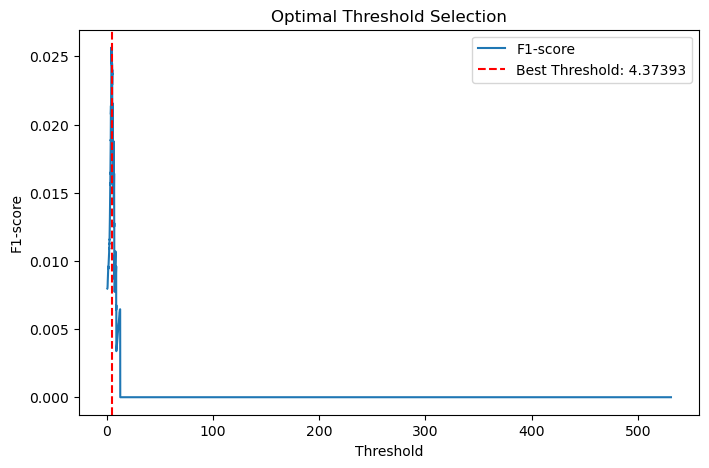

Optimal threshold based on F1-score: 4.37393
1875/1875 [==============================] - 2s 1ms/step
Accuracy: 0.8947
Precision-Recall AUC Score: 0.0097

Confusion Matrix:
[[53604  6113]
 [  205    78]]


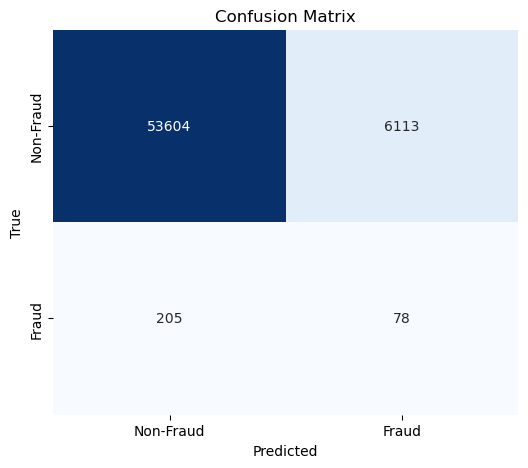


Classification Report:
              precision    recall  f1-score   support

           0     0.9962    0.8976    0.9443     59717
           1     0.0126    0.2756    0.0241       283

    accuracy                         0.8947     60000
   macro avg     0.5044    0.5866    0.4842     60000
weighted avg     0.9916    0.8947    0.9400     60000



NameError: name 'air_outcome_test' is not defined

In [56]:
# Use the autoencoder to predict reconstruction errors
# Evaluate on the test set (unseen data)
# omputes the reconstruction difference (or residual) for each feature of each sample in the test set. 
# It is a measure of how much the reconstructed data differs from the original input.
#### Squaring ensures that Negative differences are treated as positive errors and larger differences have a greater impact on the error
### Applying a mean we're actually computing the mean squared error
reconstruction_errors = np.mean(np.square(X_val_no_fraud - best_model.predict(X_val_no_fraud)), axis=1)


# Computing best reconstruction error percentile according to F1-score
# Determine a threshold
# filters the reconstruction_errors array to include only the errors corresponding to the normal samples
# es: 95% of the reconstruction errors for normal samples are below this value
# Any sample with a reconstruction error above this threshold is likely anomalous, 
### as it deviates significantly from what the autoencoder has learned to reconstruct effectively
### using error on validation in order to avoid Data Leakage
X_val_fraud = X_val[y_val == 1]
best_threshold, tested_thresholds, f1_scores = find_optimal_threshold(X_val_no_fraud, X_val_fraud, best_model)

print(f"Optimal threshold based on F1-score: {best_threshold:.5f}")


test_reconstructed = best_model.predict(X_test)
test_reconstruction_errors = np.mean(np.square(X_test - test_reconstructed), axis=1)


# Classify anomalies
anomalies = (test_reconstruction_errors > best_threshold).astype(int)


test_accuracy, test_auc, test_recall, test_f1, test_precision = compute_main_scores(y_test, anomalies, test_reconstruction_errors)


experiment_data = {
    "model_type": f"Autoencoder",
    "note": "Autoencoder light dataset with historical features",
    "dataset": "400K",
    "hyperparameters": best_params,
    "excluded_features": [],
    "best_threshold": best_threshold,
    "test_precision": test_precision,
    "test_recall": test_recall,
    "test_f1": test_f1,
    "test_accuracy": test_accuracy,
    "test_auc": test_auc,
    "test_aic": air_outcome_test,
    "test_smd": smd_test,
}

update_experiment_log(csv_path, experiment_data)
    
compare_test_performance(csv_path)

### Using 95th percentile of the reconstruction errors as the best threshold:

1868/1868 [==============================] - 2s 933us/step
Optimal threshold based on 95th percentile: 5.80157
1875/1875 [==============================] - 2s 840us/step
Accuracy: 0.9390
Precision-Recall AUC Score: 0.0090

Confusion Matrix:
[[56306  3411]
 [  247    36]]


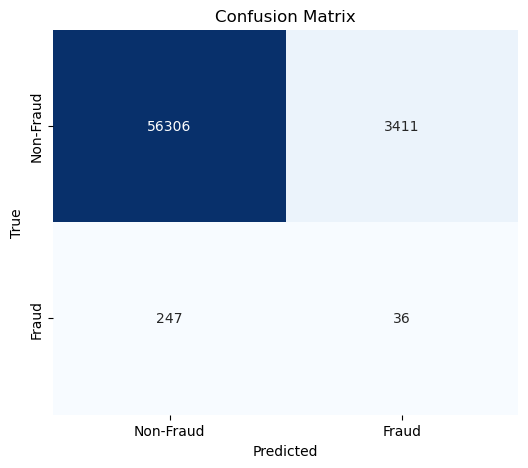


Classification Report:
              precision    recall  f1-score   support

           0     0.9956    0.9429    0.9685     59717
           1     0.0104    0.1272    0.0193       283

    accuracy                         0.9390     60000
   macro avg     0.5030    0.5350    0.4939     60000
weighted avg     0.9910    0.9390    0.9641     60000



In [17]:
# Compute reconstruction errors on validation set (non-fraud samples)
reconstruction_errors = np.mean(np.square(X_val_no_fraud - best_model.predict(X_val_no_fraud)), axis=1)

# Determine threshold using the 95th percentile of reconstruction errors
best_threshold = np.percentile(reconstruction_errors, 95)
print(f"Optimal threshold based on 95th percentile: {best_threshold:.5f}")

# Compute reconstruction errors on the test set
test_reconstructed = best_model.predict(X_test)
test_reconstruction_errors = np.mean(np.square(X_test - test_reconstructed), axis=1)

# Classify anomalies based on the new threshold
anomalies = (test_reconstruction_errors > best_threshold).astype(int)

# Compute evaluation metrics
test_accuracy, test_auc, test_recall, test_f1, test_precision = compute_main_scores(y_test, anomalies, test_reconstruction_errors)


1868/1868 [==============================] - 2s 1ms/step


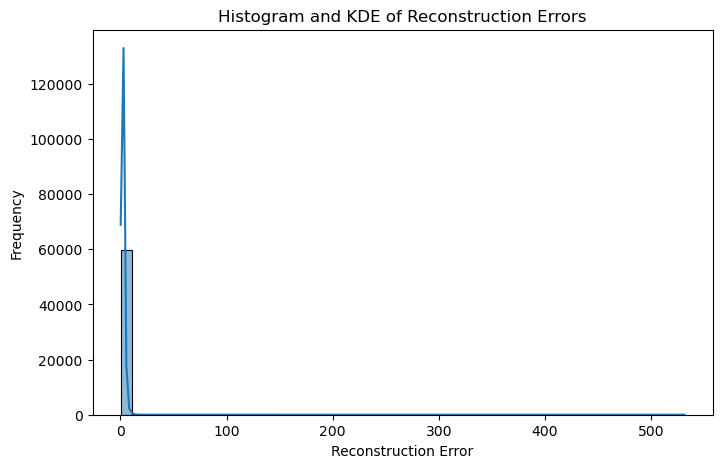

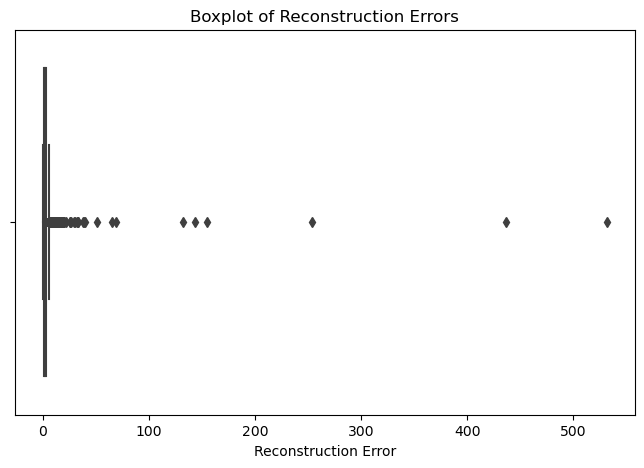

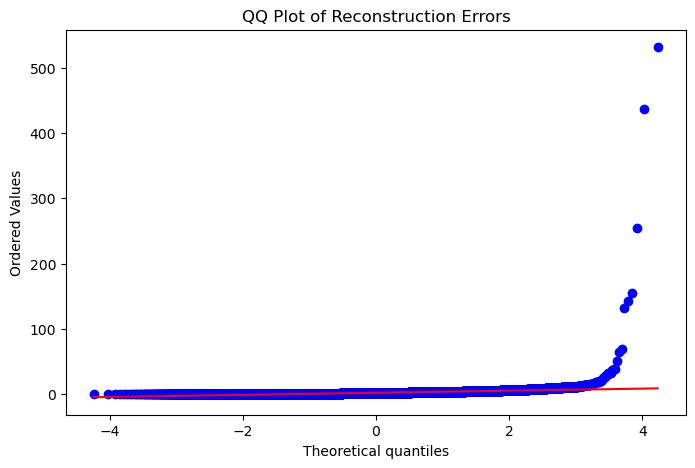

In [57]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats


reconstruction_errors = np.mean(np.square(X_val_no_fraud - best_model.predict(X_val_no_fraud)), axis=1)

# 1. Histogram + KDE Plot
plt.figure(figsize=(8, 5))
sns.histplot(reconstruction_errors, bins=50, kde=True)
plt.title("Histogram and KDE of Reconstruction Errors")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.show()

# 2. Boxplot of Reconstruction Errors
plt.figure(figsize=(8, 5))
sns.boxplot(x=reconstruction_errors)
plt.title("Boxplot of Reconstruction Errors")
plt.xlabel("Reconstruction Error")
plt.show()

# 3. QQ Plot
plt.figure(figsize=(8, 5))
stats.probplot(reconstruction_errors, dist="norm", plot=plt)
plt.title("QQ Plot of Reconstruction Errors")
plt.show()


1875/1875 [==============================] - 2s 1ms/step


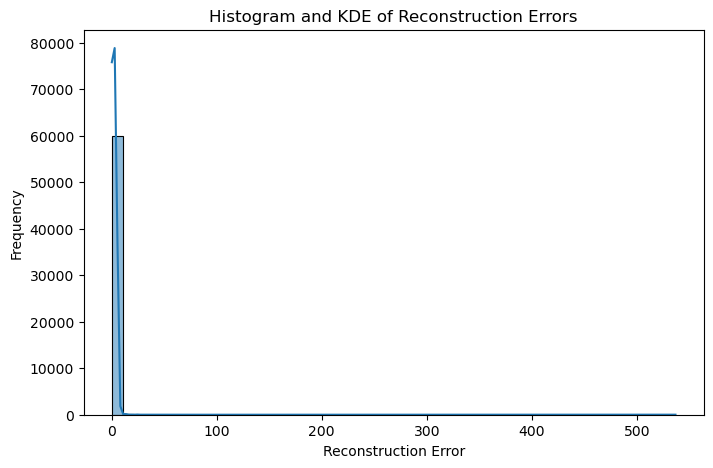

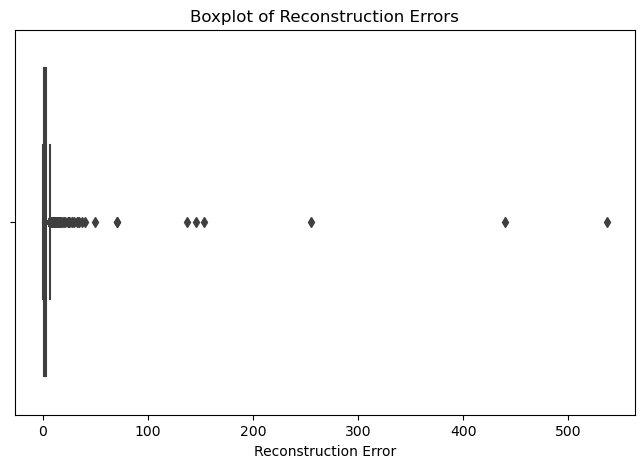

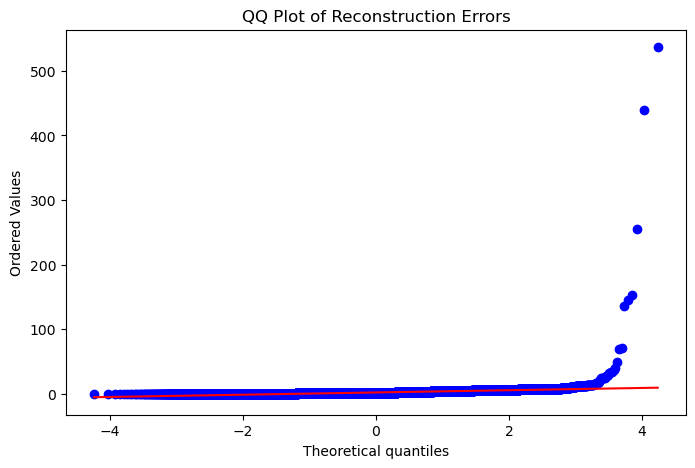

In [23]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats


reconstruction_errors = np.mean(np.square(X_val - best_model.predict(X_val)), axis=1)

# 1. Histogram + KDE Plot
plt.figure(figsize=(8, 5))
sns.histplot(reconstruction_errors, bins=50, kde=True)
plt.title("Histogram and KDE of Reconstruction Errors")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.show()

# 2. Boxplot of Reconstruction Errors
plt.figure(figsize=(8, 5))
sns.boxplot(x=reconstruction_errors)
plt.title("Boxplot of Reconstruction Errors")
plt.xlabel("Reconstruction Error")
plt.show()

# 3. QQ Plot
plt.figure(figsize=(8, 5))
stats.probplot(reconstruction_errors, dist="norm", plot=plt)
plt.title("QQ Plot of Reconstruction Errors")
plt.show()


          reconstruction_error
is_fraud                      
0                        59760
1                          240
          reconstruction_error
is_fraud                      
0                        57407
1                          207
Point-Biserial Correlation: 0.024373679688679768
P-value: 4.882261865068663e-09
Spearman Rank Correlation: 0.025170292524654143
P-value (Spearman): 1.5180981694400652e-09


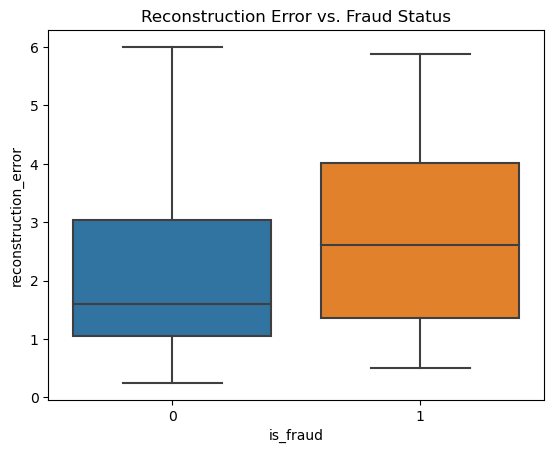

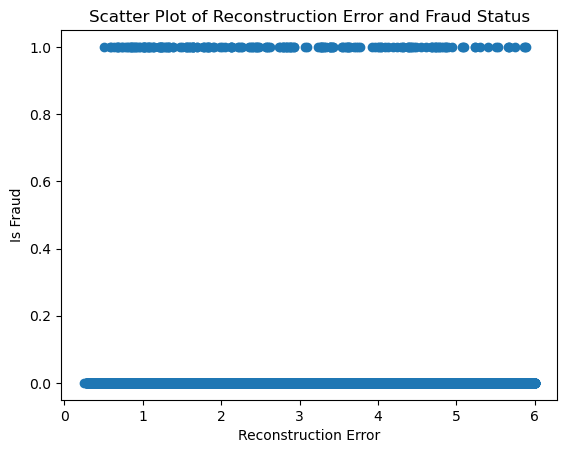

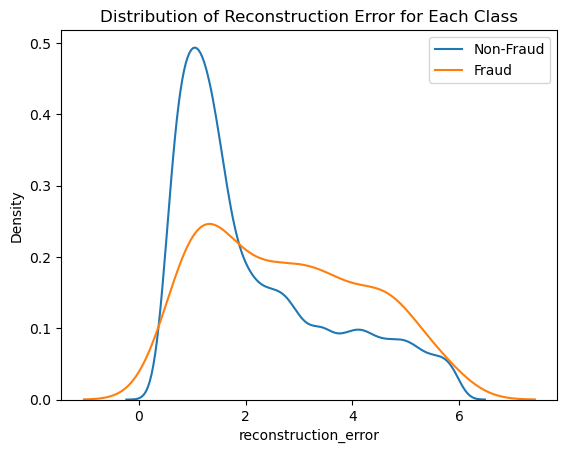

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     57407
           1       0.00      0.00      0.00       207

    accuracy                           1.00     57614
   macro avg       0.50      0.50      0.50     57614
weighted avg       0.99      1.00      0.99     57614



C:\Users\s.crispino\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\s.crispino\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\s.crispino\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [29]:
from scipy.stats import pointbiserialr, spearmanr

data = {'reconstruction_error': reconstruction_errors, 'is_fraud': y_val}
df = pd.DataFrame(data)

print(df.groupby("is_fraud").count())


correlation, p_value = pointbiserialr(df['reconstruction_error'], df['is_fraud'])
print(f"Point-Biserial Correlation: {correlation}")
print(f"P-value: {p_value}")

correlation_spearman, p_value_spearman = spearmanr(df['reconstruction_error'], df['is_fraud'])
print(f"Spearman Rank Correlation: {correlation_spearman}")
print(f"P-value (Spearman): {p_value_spearman}")


# Box plot:
sns.boxplot(x='is_fraud', y='reconstruction_error', data=df)
plt.title('Reconstruction Error vs. Fraud Status')
plt.show()

# Scatter plot (if you have a reasonable number of data points):
plt.scatter(df['reconstruction_error'], df['is_fraud']) # is_fraud is 0 or 1, so it creates two distinct lines
plt.xlabel('Reconstruction Error')
plt.ylabel('Is Fraud')
plt.title('Scatter Plot of Reconstruction Error and Fraud Status')
plt.show()

# KDE plot (Kernel Density Estimation):
sns.kdeplot(df[df['is_fraud'] == 0]['reconstruction_error'], label='Non-Fraud')
sns.kdeplot(df[df['is_fraud'] == 1]['reconstruction_error'], label='Fraud')
plt.legend()
plt.title('Distribution of Reconstruction Error for Each Class')
plt.show()


# 5. Threshold and Evaluation (as discussed before):
from sklearn.metrics import classification_report

threshold = 100 # Example: Set your threshold based on the visualizations and statistics
df['predicted_fraud'] = (df['reconstruction_error'] > threshold).astype(int)

print(classification_report(df['is_fraud'], df['predicted_fraud']))

# 4 LSTM Approach

In [35]:
# Distance between transaction and merchant locations
def haversine(lat1, lon1, lat2, lon2):
    # Radius of Earth in kilometers
    R = 6371
    # Convert degrees to radians
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda / 2)**2
    return 2 * R * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

def not_aggreageted_metric(data):
    # Convert datetime column
    data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'])
    data['hour'] = data['trans_date_trans_time'].dt.hour
    data['day'] = data['trans_date_trans_time'].dt.day
    data['month'] = data['trans_date_trans_time'].dt.month
    data['year'] = data['trans_date_trans_time'].dt.year
    data['day_of_week'] = data['trans_date_trans_time'].dt.dayofweek

    # Calculate user age
    data['dob'] = pd.to_datetime(data['dob'])
    data['age'] = (data['trans_date_trans_time'] - data['dob']).dt.days // 365

    data['distance'] = haversine(data['lat'], data['long'], data['merch_lat'], data['merch_long'])

    #Task 1: Generate number of transactions per card in specific time windows
    data['trans_date'] = pd.to_datetime(data['trans_date_trans_time']).dt.date
    data['trans_hour'] = pd.to_datetime(data['trans_date_trans_time']).dt.hour
    data['trans_month'] = pd.to_datetime(data['trans_date_trans_time']).dt.to_period('M')
    data['trans_year'] = pd.to_datetime(data['trans_date_trans_time']).dt.year
    
    data['gender'] = data['gender'].apply(lambda x: 1 if x == 'M' else 0)

    return data


def remove_useless_columns(data):   

    # Task 5: Drop specified columns
    columns_to_drop = ['zip', 'first', 'last', 'street', 'city', 'state', 
                       'lat', 'long', 'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long',
                      'trans_date', 'trans_hour', 'trans_month', 'trans_year', 'job']

    return data.drop(columns=columns_to_drop)

In [36]:


from sklearn.preprocessing import MinMaxScaler

# Assuming `get_original_training_data` is a predefined function
train, test = get_original_training_data()

# Combine train and test datasets
complete_df = pd.concat([train, test])

complete_df = not_aggreageted_metric(complete_df)

complete_df = remove_useless_columns(complete_df)

# Ensure data is sorted by transaction time (chronologically)
complete_df = complete_df.sort_values(by=['cc_num', 'trans_date_trans_time'])

# Split based on time: the first 60% for training, next 20% for validation, and the last 20% for testing
train_data = complete_df.iloc[:int(0.7 * len(complete_df))]
validation_data = complete_df.iloc[int(0.7 * len(complete_df)):int(0.85 * len(complete_df))]
test_data = complete_df.iloc[int(0.85 * len(complete_df)):]


categorical_cols = ['merchant', 'category']
label_encoders = {}

for col in categorical_cols:
    print(col)
    # Create a LabelEncoder instance
    le = LabelEncoder()

    print("Fit on training data and get classes")
    # Fit on training data and get classes
    train_classes = train_data[col].unique()
    le.fit(train_classes)

    print("Transform train_data")
    # Transform train_data
    train_data[col] = le.transform(train_data[col])

    print("Transform validation_data")
    # Transform validation_data
    validation_data[col] = le.transform(validation_data[col])

    print("Transform test_data")
    # Transform test_data
    test_data[col] = le.transform(test_data[col])

    # Save the LabelEncoder for future use
    label_encoders[col] = le
    

not_numerical = ['merchant', 'category', 'cc_num', 'trans_date_trans_time', 'is_fraud']

continuous_cols = list(set(train_data.columns) - set(not_numerical))
print("continuous_cols: ", continuous_cols)
    
#scaler = MinMaxScaler()
#print("fit_transform train_data")
#train_data[continuous_cols] = scaler.fit_transform(train_data[continuous_cols])
#print("transform validation_data")
#validation_data[continuous_cols] = scaler.transform(validation_data[continuous_cols])  # Scale validation data
#print("transform test_data")
#test_data[continuous_cols] = scaler.transform(test_data[continuous_cols])

train shape  (340000, 22)
test shape  (60000, 22)
merchant
Fit on training data and get classes
Transform train_data
Transform validation_data
Transform test_data
category
Fit on training data and get classes
Transform train_data
Transform validation_data
Transform test_data
continuous_cols:  ['distance', 'city_pop', 'amt', 'age', 'day', 'hour', 'day_of_week', 'month', 'gender', 'year']


C:\Users\s.crispino\AppData\Local\Temp\ipykernel_27888\1732126038.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[col] = le.transform(train_data[col])
C:\Users\s.crispino\AppData\Local\Temp\ipykernel_27888\1732126038.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_data[col] = le.transform(validation_data[col])
C:\Users\s.crispino\AppData\Local\Temp\ipykernel_27888\1732126038.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

In [37]:
# Group by user (cc_num) and count the transactions per user
transactions_per_user = complete_df.groupby('cc_num').size()

transactions_per_user.describe()

count     919.000000
mean      435.255713
std       235.469699
min         7.000000
25%       181.000000
50%       446.000000
75%       619.000000
max      1038.000000
dtype: float64

Middle ground: Given that the median number of transactions per user is 435 and the 75th percentile is 619, 50 has been chosed as sequence length. This range should be able to capture enough temporal dependencies without being too expensive for training.

In [38]:
import numpy as np
from tqdm import tqdm  # Import tqdm for progress bar
from sklearn.preprocessing import MinMaxScaler

def create_sequences(df, seq_length=100):
    sequences = []
    labels = []

    # Using tqdm to track progress over users
    for cc_num, group in tqdm(df.groupby('cc_num'), desc="Processing Users"):
        # Skip users with less than 'seq_length' transactions
        if len(group) < seq_length:
            continue
        
        for i in range(seq_length, len(group)):
            seq = group.iloc[i-seq_length:i].drop(columns=['cc_num', 'trans_date_trans_time', 'is_fraud'])  # Remove non-feature columns
            label = group.iloc[i]['is_fraud']  # Fraud label for the current transaction
            sequences.append(seq.values)
            labels.append(label)

    return np.array(sequences), np.array(labels)

# final_train_data, final_validation_data, final_test_data

scaler = MinMaxScaler()

# Fit and transform training data
train_data[continuous_cols] = scaler.fit_transform(train_data[continuous_cols])

# Transform validation and test data (using the scaler fitted on training data)
validation_data[continuous_cols] = scaler.transform(validation_data[continuous_cols])
test_data[continuous_cols] = scaler.transform(test_data[continuous_cols])

X_train, y_train = create_sequences(train_data, seq_length=25)
X_val, y_val = create_sequences(validation_data, seq_length=25)
X_test, y_test = create_sequences(test_data, seq_length=25)

# Check the shapes of the normalized data
print(X_train.shape, X_val.shape, X_test.shape)



C:\Users\s.crispino\AppData\Local\Temp\ipykernel_27888\2469908464.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[continuous_cols] = scaler.fit_transform(train_data[continuous_cols])
C:\Users\s.crispino\AppData\Local\Temp\ipykernel_27888\2469908464.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_data[continuous_cols] = scaler.transform(validation_data[continuous_cols])
C:\Users\s.crispino\AppData\Local\Temp\ipykernel_27888\2469908464.py:32: SettingWithCopyWarning: 
A value is

(264087, 25, 12) (56565, 25, 12) (56489, 25, 12)


In [39]:
print(y_train.sum() / y_train.shape)
print(y_val.sum() / y_val.shape)
print(y_test.sum() / y_test.shape)

[0.00457046]
[0.00337665]
[0.00378835]


In [40]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: weight for i, weight in enumerate(class_weights)}

class_weights

{0: 0.5022957242848448, 1: 109.39809444904722}

In [41]:
# Initialize variables to track the best model
best_model = None
best_params = None
best_val_auc = -np.inf
validation_performance = {}

In [42]:
# Clear Keras/TensorFlow Session
K.clear_session()
# Force Garbage Collection
gc.collect()


17665

In [70]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import roc_auc_score
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm

# Define hyperparameters to tune
param_grid = {
    'num_blocks_list': [[3]],  # Defines different numbers of LSTM layers
    'batch_size': [128],
    'units': [512],
    'dropout': [0.0],
    'learning_rate': [0.0001],
    'regularization': ['l1'],
    'reg_strength': [0.0001],
    'class_weights': [class_weights],    
}

# Create combinations of hyperparameters
param_combinations = list(ParameterGrid(param_grid))


best_val_auc = 0.0
best_model = None
best_params = None

with tqdm(total=len(param_combinations), desc="Hyperparameter Tuning") as pbar:
    for params in param_combinations:
        print(f"\nTraining with parameters: {params}")
        
        # Define the regularizer
        if params['regularization'] == 'l1':
            regularizer = l1(params['reg_strength'])
        elif params['regularization'] == 'l2':
            regularizer = l2(params['reg_strength'])
        elif params['regularization'] == 'l1_l2':
            regularizer = l1_l2(params['reg_strength'], params['reg_strength'])
        
        # Build the LSTM model dynamically
        model = Sequential()
        model.add(LSTM(units=params['units'], return_sequences=True, 
                       input_shape=(X_train.shape[1], X_train.shape[2]),
                       kernel_regularizer=regularizer
                      ))
        model.add(Dropout(params['dropout']))
        
        for i in range(1, max(params['num_blocks_list']) + 1):
            model.add(LSTM(units=max(params['units'] // (2 ** i), 8), 
                            return_sequences=(i < max(params['num_blocks_list'])),
                            kernel_regularizer=regularizer
                          ))
            model.add(Dropout(params['dropout']))
        
        model.add(Dense(1, activation='sigmoid'))
        
        # Compile the model
        optimizer = Adam(learning_rate=params['learning_rate'])
        model.compile(
            optimizer=optimizer, loss='binary_crossentropy', 
            metrics=['accuracy', tf.keras.metrics.AUC(curve='PR', name='pr_auc')]
        )
        
        print(model.summary())
        
        # Early stopping
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        
        # Train the model
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=50,
            batch_size=params['batch_size'],
            class_weight=params['class_weights'],
            callbacks=[early_stopping]
        )
        
        print("Plotting training and validation metrics across epochs")
        plot_performance(history)
        
        # Evaluate AUC on validation set
        y_val_pred = model.predict(X_val)
        y_val_pred_classes = (y_val_pred >= 0.5).astype(int)
        
        val_accuracy, val_auc, val_recall, val_f1, val_precision = compute_main_scores(
            y_val, y_val_pred_classes, y_val_pred
        )
        
        # Add sequence_length dynamically
        validation_performance = {
            "num_blocks_list": params['num_blocks_list'],
            "sequence_length": X_train.shape[1],  # Added sequence length
            "model_type": "LSTM",
            "units": params['units'],
            "dropout": params['dropout'],
            "learning_rate": params['learning_rate'],
            "batch_size": params['batch_size'],
            "regularization": params['regularization'],
            "reg_strength": params['reg_strength'],
            "class_weights": params['class_weights'],
            "val_precision": val_precision,
            "val_recall": val_recall,
            "val_f1": val_f1,
            "val_accuracy": val_accuracy,
            "val_auc": val_auc
        }
        
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            best_model = model
            best_params = params
        else:
            del model
        
        print("BEST PARAMS SO FAR:")
        print("BEST VAL AUC: ", best_val_auc)
        print(best_params)
        
        # Save results
        save_validation_info(validation_performance, "LSTM_validation_data_2.csv")
        
        # Clear Keras/TensorFlow Session
        K.clear_session()
        # Force Garbage Collection
        gc.collect()
        
        
        pbar.update(1)

print(f"Best Hyperparameters: {best_params}")
print(f"Best Validation AUC: {best_val_auc:.4f}")


Hyperparameter Tuning:   0%|                                                                     | 0/1 [00:00<?, ?it/s]


Training with parameters: {'batch_size': 128, 'class_weights': {0: 0.5022957242848448, 1: 109.39809444904722}, 'dropout': 0.0, 'learning_rate': 0.0001, 'num_blocks_list': [3], 'reg_strength': 0.0001, 'regularization': 'l1', 'units': 512}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 25, 512)           1075200   
                                                                 
 dropout (Dropout)           (None, 25, 512)           0         
                                                                 
 lstm_1 (LSTM)               (None, 25, 256)           787456    
                                                                 
 dropout_1 (Dropout)         (None, 25, 256)           0         
                                                                 
 lstm_2 (LSTM)               (None, 25, 128)           197120    
               

Hyperparameter Tuning:   0%|                                                                     | 0/1 [34:27<?, ?it/s]


KeyboardInterrupt: 

1768/1768 [==============================] - 124s 70ms/step
Best Threshold (Recall >= 0.7 & Max F1-Score): 0.35
Precision: 0.05, Recall: 0.70, F1-Score: 0.09


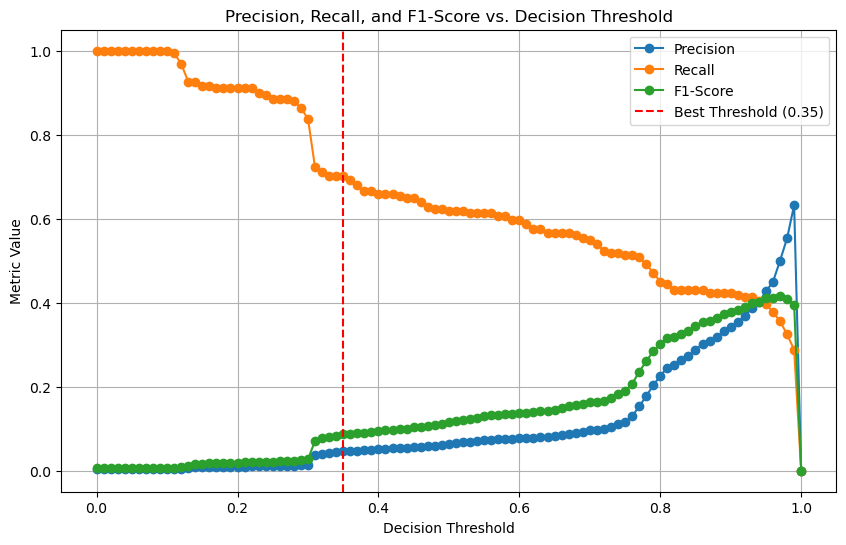

Best Threshold: 0.35000000000000003
1766/1766 [==============================] - 130s 74ms/step
Accuracy: 0.9514
Precision-Recall AUC Score: 0.3527

Confusion Matrix:
[[53611  2664]
 [   84   130]]


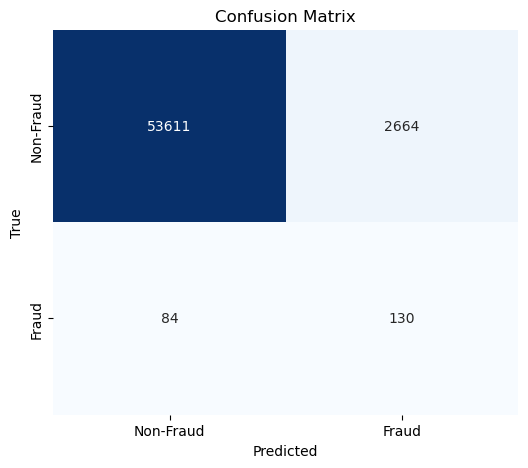


Classification Report:
              precision    recall  f1-score   support

           0     0.9984    0.9527    0.9750     56275
           1     0.0465    0.6075    0.0864       214

    accuracy                         0.9514     56489
   macro avg     0.5225    0.7801    0.5307     56489
weighted avg     0.9948    0.9514    0.9716     56489

Test Metrics:
Accuracy: 0.9514
AUC: 0.3527
Recall: 0.6075
F1 Score: 0.0864
Precision: 0.0465
Experiment data saved to experiment_log_light_dataset_historical_features.csv


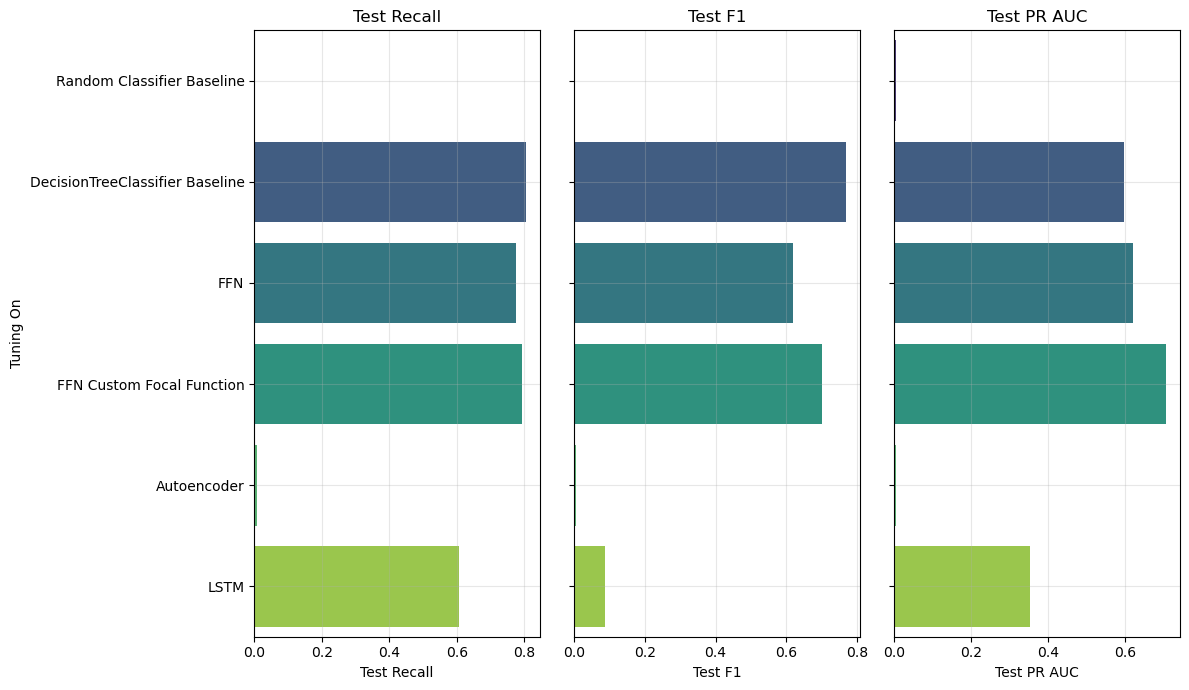

In [23]:


# Evaluate the best model's threshold on the validation set
best_threshold = threshold_metric_evaluation(best_model, X_val, y_val)
print(f"Best Threshold: {best_threshold}")

# Test the best model on the test set
y_test_pred = best_model.predict(X_test)
y_test_pred_classes = (y_test_pred >= best_threshold).astype(int)

# Compute main scores
test_accuracy, test_auc, test_recall, test_f1, test_precision = compute_main_scores(
    y_test, y_test_pred_classes, y_test_pred
)

# Print test evaluation metrics
print("Test Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"AUC: {test_auc:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print(f"Precision: {test_precision:.4f}")

# Fairness evaluation
#integrated_df_test, smd_test, air_outcome_test, air_out_accuracy_test = fairness_evaluation(
#    best_model, X_test, y_test, y_test_pred_classes, "gender", 0, 1, 0
#)


experiment_data = {
    "model_type": f"LSTM",
    "note": "LSTM light dataset with historical features",
    "dataset": "400K",
    "hyperparameters": best_params,
    "excluded_features": [],
    "best_threshold": best_threshold,
    "test_precision": test_precision,
    "test_recall": test_recall,
    "test_f1": test_f1,
    "test_accuracy": test_accuracy,
    "test_auc": test_auc,
    "test_aic": None,
    "test_smd": None,
}

save_experiment_data(experiment_data, csv_path)

compare_test_performance(csv_path)

In [74]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import roc_auc_score
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm
from tensorflow.keras import backend as K
import gc

# Define hyperparameters to tune (more options)
param_grid = {
    'lstm_units': [128],  # Units in LSTM layers
    'num_lstm_layers': [4],    # Number of LSTM layers
    'dropout': [0.1],       # Dropout rate
    'learning_rate': [0.0001, 0.001], # Learning rate
    'batch_size': [256],      # Batch size
    'l1_reg': [0.0, 0.001],      # L1 regularization strength
    'l2_reg': [0.001, 0.001],      # L2 regularization strength
    'class_weights': [class_weights], # Class weights (calculated beforehand)
}

param_combinations = list(ParameterGrid(param_grid))

best_val_auc = 0.0
best_model = None
best_params = None

with tqdm(total=len(param_combinations), desc="Hyperparameter Tuning") as pbar:
    for params in param_combinations:
        print(f"\nTraining with parameters: {params}")

        model = Sequential()

        # Input LSTM layer
        model.add(LSTM(units=params['lstm_units'], return_sequences=(params['num_lstm_layers'] > 1),
                       input_shape=(X_train.shape[1], X_train.shape[2]),
                       kernel_regularizer=l1_l2(l1=params['l1_reg'], l2=params['l2_reg'])))  # Apply regularization
        model.add(Dropout(params['dropout']))
        model.add(BatchNormalization()) # Add Batch Normalization
        
        units = params['lstm_units']
        # Additional LSTM layers (if needed)
        for _ in range(params['num_lstm_layers'] - 2):
            units = units // 2
            model.add(LSTM(units=units,  # Reduce units in subsequent layers
                           return_sequences=True,  # Keep sequences for subsequent LSTMs
                           kernel_regularizer=l1_l2(l1=params['l1_reg'], l2=params['l2_reg'])))
            model.add(Dropout(params['dropout']))
            model.add(BatchNormalization()) # Add Batch Normalization
        
        units = units // 2
        model.add(LSTM(units=units,  # Reduce units in subsequent layers
                           return_sequences=False,  # Keep sequences for subsequent LSTMs
                           kernel_regularizer=l1_l2(l1=params['l1_reg'], l2=params['l2_reg'])))
        model.add(Dropout(params['dropout']))
        model.add(BatchNormalization()) # Add Batch Normalization
        
        units = units // 2
        # Dense layers (before output)
        model.add(Dense(units=units, activation='relu',
                       kernel_regularizer=l1_l2(l1=params['l1_reg'], l2=params['l2_reg'])))
        model.add(Dropout(params['dropout']))
        model.add(BatchNormalization()) # Add Batch Normalization

        model.add(Dense(1, activation='sigmoid'))  # Output layer

        optimizer = Adam(learning_rate=params['learning_rate'])
        model.compile(optimizer=optimizer, loss='binary_crossentropy',
                      metrics=['accuracy', tf.keras.metrics.AUC(curve='PR', name='pr_auc')])

        print(model.summary())

        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        history = model.fit(X_train, y_train,
                            validation_data=(X_val, y_val),
                            epochs=50,
                            batch_size=params['batch_size'],
                            class_weight=params['class_weights'],
                            callbacks=[early_stopping])

        
        print("Plotting training and validation metrics across epochs")
        plot_performance(history)
        
        # Evaluate AUC on validation set
        y_val_pred = model.predict(X_val)
        y_val_pred_classes = (y_val_pred >= 0.5).astype(int)
        
        val_accuracy, val_auc, val_recall, val_f1, val_precision = compute_main_scores(
            y_val, y_val_pred_classes, y_val_pred
        )
        
        # Add sequence_length dynamically
        validation_performance = {
            "num_blocks_list": params['num_blocks_list'],
            "sequence_length": X_train.shape[1],  # Added sequence length
            "model_type": "LSTM",
            "units": params['units'],
            "dropout": params['dropout'],
            "learning_rate": params['learning_rate'],
            "batch_size": params['batch_size'],
            "regularization": params['regularization'],
            "reg_strength": params['reg_strength'],
            "class_weights": params['class_weights'],
            "val_precision": val_precision,
            "val_recall": val_recall,
            "val_f1": val_f1,
            "val_accuracy": val_accuracy,
            "val_auc": val_auc
        }
        
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            best_model = model
            best_params = params
        else:
            del model
        
        print("BEST PARAMS SO FAR:")
        print("BEST VAL AUC: ", best_val_auc)
        print(best_params)
        
        # Save results
        save_validation_info(validation_performance, "LSTM_validation_data_2.csv")
        
        # Clear Keras/TensorFlow Session
        K.clear_session()
        # Force Garbage Collection
        gc.collect()
        
        
        pbar.update(1)

print(f"Best Hyperparameters: {best_params}")
print(f"Best Validation AUC: {best_val_auc:.4f}")


Hyperparameter Tuning:   0%|                                                                     | 0/8 [00:00<?, ?it/s]


Training with parameters: {'batch_size': 256, 'class_weights': {0: 0.5022957242848448, 1: 109.39809444904722}, 'dropout': 0.1, 'l1_reg': 0.0, 'l2_reg': 0.001, 'learning_rate': 0.0001, 'lstm_units': 128, 'num_lstm_layers': 4}
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_147 (LSTM)             (None, 25, 128)           72192     
                                                                 
 dropout_177 (Dropout)       (None, 25, 128)           0         
                                                                 
 batch_normalization_177 (B  (None, 25, 128)           512       
 atchNormalization)                                              
                                                                 
 lstm_148 (LSTM)             (None, 25, 64)            49408     
                                                                 
 dropout_178 (Dropout)   

Hyperparameter Tuning:   0%|                                                                     | 0/8 [11:02<?, ?it/s]


KeyboardInterrupt: 

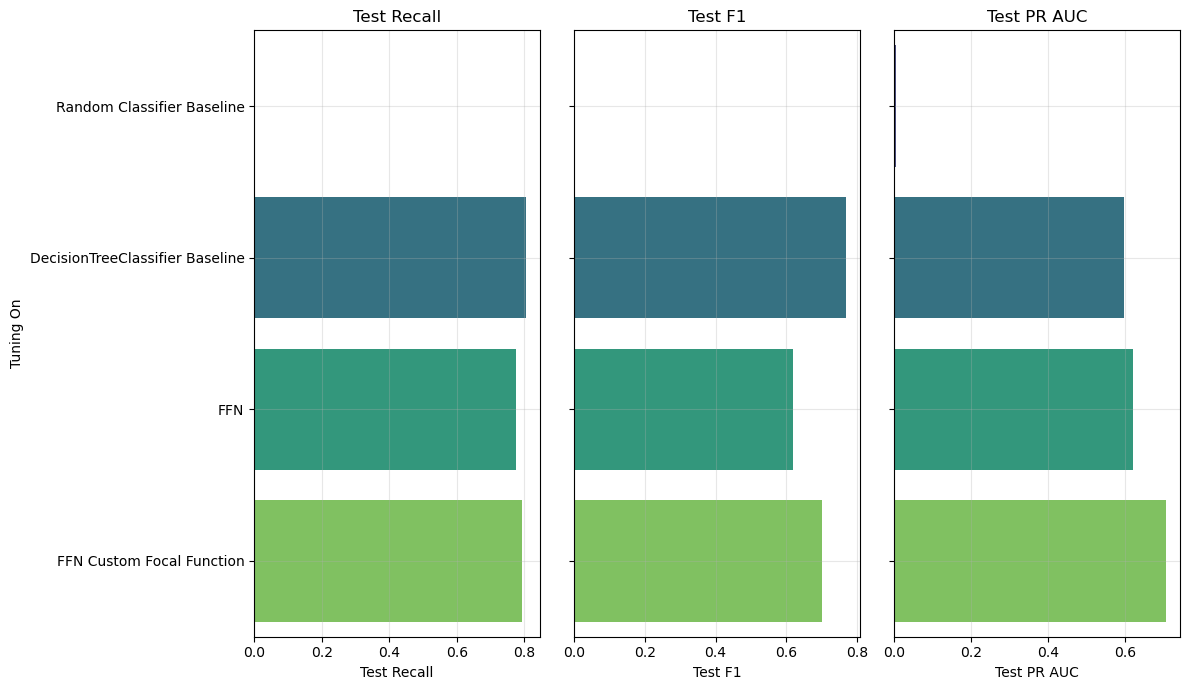

In [75]:
compare_test_performance(csv_path)